In [1]:
import re
import os
import numpy as np
import pandas as pd

from tqdm import trange
import matplotlib.pyplot as plt
from src.SDL_SVP import SDL_SVP
from src.SDL_BCD import SDL_BCD

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import SparseCoder
from sklearn.metrics import roc_curve
from scipy.spatial import ConvexHull

from sklearn.datasets import fetch_openml
from PIL import Image, ImageOps

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def generate_Y(H, Beta, n):
    Y = np.zeros(n)
    prob = sigmoid(H @ Beta - np.mean(H @ Beta))
  
    for i in range(n):
        U = np.random.rand()
        if U < prob[i]:
            Y[i] = 1
    print('proportion of 1s:', np.sum(Y)/n)
    return Y    

def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def sample_MNIST(X, y, list_digits = ['1', '2'], basis_size=None):
    
    # get subset of data from MNIST of given digits
    # basis_size = [r1, r2]
    
    Y = list2onehot(y.tolist(), list_digits)

    ## Sampling 
    idx = []
    for j in range(len(list_digits)):
      idx0 = [i for i in range(len(y)) if y[i] == list_digits[j]] 
      if basis_size is None:
        idx = idx + idx0
      if basis_size is not None:
        idx = idx + list(np.random.choice(idx0, basis_size[j], replace = False))

    X0 = X[idx,:]
    y0 = Y[idx,:]

    return X0, y0    

def sim_data_gen_MNIST(r = [2, 2], n = 1000,
                       digits_X = ['2', '7'],
                       digits_Y = ['1', '4'],
                       noise_std = 0,
                       random_seed = 1):
    
    np.random.seed(random_seed)

    # Load data
    X, y = fetch_openml('mnist_784', version = 1, return_X_y = True) # pandas dataframe
    X = X / 255.
    X = np.asarray(X) 

    W_true, temp = sample_MNIST(X, y, list_digits = digits_X, basis_size = r)
    W_true_Y, y0 = sample_MNIST(X, y, list_digits = digits_Y, basis_size = r)
    p = W_true.shape[1] 

    Beta_true = (2*y0[:,0]-1) # 1 if Y = first digit, -1 if Y = second digit
    print('Beta_true', Beta_true)

    Sigma = ((noise_std)**2) * np.eye(p)
    Noise = np.random.multivariate_normal(np.zeros(p),  Sigma, n)

    H_true = np.random.rand(n, sum(r))
    X = H_true @ W_true

    Y = generate_Y(X @ W_true.T, Beta_true, n) # true labels
    X += Noise # corrupt true signal

    X_train, X_test, Y_train, Y_test, H_train, H_test = train_test_split(X, Y, H_true, test_size = 0.2)
    
    X, X_train, X_test = X.T, X_train.T, X_test.T
    H_true, H_train, H_test = H_true.T, H_train.T, H_test.T
    Y, Y_train, Y_test = Y[np.newaxis,:], Y_train[np.newaxis,:], Y_test[np.newaxis,:]
    W_true, W_true_Y, Beta_true = W_true.T, W_true_Y.T, Beta_true[np.newaxis,:]

    print('X_train.shape', X_train.shape)
    print('Y_train.shape', Y_train.shape)
    print('X_test.shape', X_test.shape)
    print('Y_test.shape', Y_test.shape)

    return X_train, X_test, Y_train, Y_test, W_true, W_true_Y, H_true, H_train, H_test, Beta_true

def compute_accuracy_metrics(Y_test, P_pred, train_data=None, verbose=False):
    # y_test = binary label
    # P_pred = predicted probability for y_test
    # train_data = [X_train, ]
    # compuate various binary classification accuracy metrics
    # Compute classification statistics

    if train_data is not None:
        Y_train, P_train = train_data
        fpr, tpr, thresholds = metrics.roc_curve(Y_train, P_train, pos_label=None)
        mythre = thresholds[np.argmax(tpr - fpr)]
        myauc = round(metrics.auc(fpr, tpr), 4)
        print('threshold from training set used:', mythre)
    else:
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
        mythre = thresholds[np.argmax(tpr - fpr)]
        myauc = round(metrics.auc(fpr, tpr), 4)

    threshold = round(mythre, 4)

    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = round( (tp + tn) / (tp + tn + fp + fn), 4)
    misclassification = round(1 - accuracy, 4)
    sensitivity = round(tp / (tp + fn), 4)
    specificity = round(tn / (tn + fp), 4)
    precision = round(tp / (tp + fp), 4)
    recall = round(tp / (tp + fn), 4)
    fall_out = round(fp / (fp + tn), 4)
    miss_rate = round(fn / (fn + tp), 4)
    F_score = round(2 * precision * recall / ( precision + recall ), 4)

    # Save results
    results_dict = {}
    #results_dict.update({'Y_test': Y_test})
    #results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': threshold})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    #results_dict.update({'Fall_out': fall_out})
    #results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'F_score': F_score})

    if verbose:
        for key in [key for key in results_dict.keys() if key not in ['Y_test', 'Y_pred']]:
            print('% s ===> %.3f' % (key, results_dict.get(key)))
    return results_dict

def coding(X, W, H0,
          r=None,
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5],
          stopping_grad_ratio=0.0001,
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    if H0 is None:
        H0 = np.random.rand(W.shape[1],X.shape[1])

    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation

    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
        # print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H1)**2))
    return H1

def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):

        '''
        Given data matrix X, use alternating least squares to find factors W,H so that
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''

        d, n = X.shape
        r = n_components

        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors
        W = np.random.rand(d,r)
        H = np.random.rand(r,n)
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            #H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            #W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

    

In [3]:
def display_dictionary_list(W_list, grid_shape=None, fig_size=None, label_list=None, save_path=None, score_list=None):
    
    # Make plot
    
    # outer gridspec
    if fig_size is None:
        figsize = [10, 10]
    else: 
        figsize = fig_size
    
    fig = plt.figure(figsize=figsize, constrained_layout=False)
    outer_grid = gridspec.GridSpec(nrows=1, ncols=1, wspace=0.1, hspace=0.05)

    # make nested gridspecs
    
    k = int(np.sqrt(W_list.shape[0]))
    if grid_shape is None:
        sub_rows = int(np.ceil(np.sqrt(W_list.shape[1])))
        sub_cols = int(np.floor(np.sqrt(W_list.shape[1])))
    else:
        sub_rows, sub_cols = grid_shape[0], grid_shape[1]

    idx = np.arange(W_list.shape[1])
    if score_list is not None:
        idx = np.argsort(score_list)
        idx = np.flip(idx)    

    inner_grid = outer_grid[0].subgridspec(sub_rows, sub_cols, wspace=0.05, hspace=0.05)

    for j in range(sub_rows*sub_cols):
        a = j // sub_cols 
        b = j % sub_cols #sub-lattice indices

        ax = fig.add_subplot(inner_grid[a, b])
        ax.imshow(W_list.T[idx[j]].reshape(k, k), cmap="viridis", interpolation='nearest')
        ax.set_xticks([])
        if (b>0):
            ax.set_yticks([])
        if (a < sub_rows-1):
            ax.set_xticks([])
        if (score_list is not None):
            ax.set_xlabel('%1.2f' % score_list[idx[j]], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.07)
           
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    #if save_path is not None:
    #    plt.savefig(save_nasave_pathme, bbox_inches='tight')
    
def display_dictionary_list2(W_list, grid_shape=None, fig_size=None, label_list=None, save_path=None, score_list=None):
    
    # Make plot
    
    # outer gridspec
    nrows=1
    ncols=len(W_list)
    
    if fig_size is None:
        figsize = [10, 10]
    else: 
        figsize = fig_size
        
    fig = plt.figure(figsize=fig_size, constrained_layout=False)
    outer_grid = gridspec.GridSpec(nrows=nrows, ncols=ncols, wspace=0.1, hspace=0.05)

    # make nested gridspecs
    for i in range(1 * ncols):
        k = int(np.sqrt(W_list[i].shape[0]))
        if grid_shape is None:
            sub_rows = int(np.ceil(np.sqrt(W_list[i].shape[1])))
            sub_cols = int(np.floor(np.sqrt(W_list[i].shape[1])))
        else:
            sub_rows, sub_cols = grid_shape[0], grid_shape[1]
            
        idx = np.arange(W_list[i].shape[1])
        if score_list is not None:
            idx = np.argsort(score_list[i])
            idx = np.flip(idx)    
        
        inner_grid = outer_grid[i].subgridspec(sub_rows, sub_cols, wspace=0.05, hspace=0.05)

        for j in range(sub_rows*sub_cols):
            a = j // sub_cols 
            b = j % sub_cols #sub-lattice indices

            ax = fig.add_subplot(inner_grid[a, b])
            ax.imshow(W_list[i].T[idx[j]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xticks([])
            if (b>0):
                ax.set_yticks([])
            if (a < sub_rows-1):
                ax.set_xticks([])
            if (a == 0) and (b==2):
                #ax.set_title("W_nonnegativity$=$ %s \n H_nonnegativity$=$ %s" 
                #             % (str(nonnegativity_list[i][0]), str(nonnegativity_list[i][1])), y=1.2, fontsize=14) 
                if label_list is not None:
                    ax.set_title(label_list[i], y=1.2, fontsize=14)
            if (score_list is not None) and (score_list[i] is not None):
                ax.set_xlabel('%1.2f' % score_list[i][idx[j]], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.07)
           
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    #if save_path is not None:
    #    plt.savefig(save_nasave_pathme, bbox_inches='tight')
       


In [4]:
r0 = 1
X_train, X_test, Y_train, Y_test, W_true, W_true_Y, H_true, H_train, H_test, Beta_true = sim_data_gen_MNIST(r = [r0, r0], n = 1000, digits_X = ['2', '5'], digits_Y = ['4', '7'], noise_std = 1, random_seed = 1)

Beta_true [ 1 -1]
proportion of 1s: 0.494
X_train.shape (784, 800)
Y_train.shape (1, 800)
X_test.shape (784, 200)
Y_test.shape (1, 200)


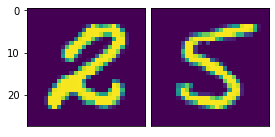

In [5]:
display_dictionary_list(W_true, grid_shape=[1,2], fig_size=[4,4])

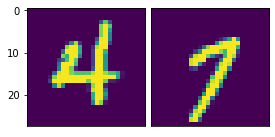

In [6]:
display_dictionary_list(W_true_Y, grid_shape=[1,2], fig_size=[4,4])
# first one - 1 / second picture - 0

In [62]:
results_dict_list = []
iteration = 300
r = 2*r0

### LR
clf = LogisticRegression(random_state=0).fit(X_train.T, Y_train[0,:])
P_train = clf.predict_proba(X_train.T)
P_pred = clf.predict_proba(X_test.T)
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)

results.update({'method': 'LR'})
results.update({'xi': None})
results.update({'Relative_reconstruction_loss (test)': 1})
results_dict_list.append(results.copy())
results_dict_list

threshold from training set used: 0.9598646575906705
AUC ===> 1.000
Opt_threshold ===> 0.960
Accuracy ===> 0.800
Sensitivity ===> 0.678
Specificity ===> 0.900
Precision ===> 0.847
F_score ===> 0.753


[{'AUC': 1.0,
  'Opt_threshold': 0.9599,
  'Accuracy': 0.8,
  'Sensitivity': 0.6778,
  'Specificity': 0.9,
  'Precision': 0.8472,
  'F_score': 0.7531,
  'method': 'LR',
  'xi': None,
  'Relative_reconstruction_loss (test)': 1}]

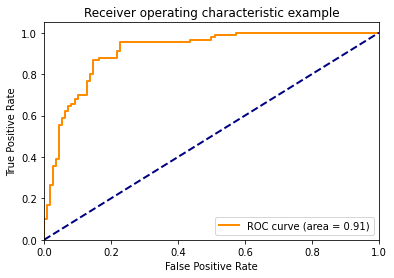

In [63]:
fpr, tpr, _ = roc_curve(Y_test[0], P_pred[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [27]:
# MF --> LR
print('MF->LR')
W, H = ALS(X_train,
            n_components = r, # number of columns in the dictionary matrix W
            n_iter=iteration,
            a0 = 0, # L1 regularizer for H
            a1 = 0, # L1 regularizer for W
            a12 = 0, # L2 regularizer for W
            H_nonnegativity=True,
            W_nonnegativity=True,
            compute_recons_error=False,
            subsample_ratio = 1)

clf = LogisticRegression(random_state=0).fit((W.T @ X_train).T, Y_train[0,:])
P_train = clf.predict_proba((W.T @ X_train).T)
P_pred = clf.predict_proba((W.T @ X_test).T)
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data=[Y_train[0], P_train[:,1]], verbose=True)
results.update({'xi': None})
results.update({'method': 'MF-->LR'})

coder = SparseCoder(dictionary=W.T, transform_n_nonzero_coefs=None,
                        transform_alpha=0, transform_algorithm='lasso_lars', positive_code=True)
H1 = coder.transform(X_test.T).T
error_data = np.linalg.norm((X_test - W @ H1).reshape(-1, 1), ord=2)**2
rel_error_data = error_data / np.linalg.norm(X_test.reshape(-1, 1), ord=2)**2
results.update({'Relative_reconstruction_loss (test)': rel_error_data})
results_dict_list.append(results.copy())

  1%|▋                                                    | 4/300 [00:00<00:07, 38.53it/s]

MF->LR


100%|███████████████████████████████████████████████████| 300/300 [00:08<00:00, 35.62it/s]


threshold from training set used: 0.4402973316708951
AUC ===> 0.961
Opt_threshold ===> 0.440
Accuracy ===> 0.880
Sensitivity ===> 0.911
Specificity ===> 0.855
Precision ===> 0.837
F_score ===> 0.872


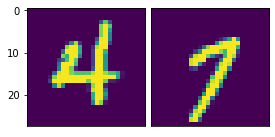

In [46]:
display_dictionary_list2([W_true_Y], grid_shape=[1,2], fig_size=[4,4])

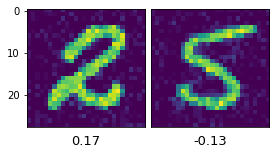

In [44]:
display_dictionary_list2([W], grid_shape=[1,2], fig_size=[4,4], score_list = clf.coef_)

In [47]:
### SNMF - filter_based learning

iteration1 = 200

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

SNMF_AUC_array = np.zeros(shape=[iter_avg, len(xi_list)])
for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SNMF_class_new = SNMF(X=[X_train, Y_train],  # data, label
                        X_test=[X_test, Y_test],
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initialization for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        #ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        #ini_code = H_true, 
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

        results_dict_new_snmf_cv = SNMF_class_new.train_logistic(iter=iteration1, subsample_size=None, 
                                                beta = beta,
                                                search_radius_const=1,
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)
        #results_dict_new.update({'method': 'SDL-filt'})
        #results_dict_new.update({'beta': beta})
        #results_dict_list.append(results_dict_new.copy())
        SNMF_AUC_array[i, j] = results_dict_new_snmf_cv.get('Accuracy')
        # print('Beta_learned', results_dict.get('loading')[1])

print(np.sum(SNMF_AUC_array, 0))        
xi_SNMF = xi_list[np.argmax(np.sum(SNMF_AUC_array, 0))]

100%|███████████████████████████████████████████████████| 200/200 [00:22<00:00,  8.93it/s]


[1.665 1.68  1.715 1.71 ]


In [50]:
beta = 1
xi_SNMF = xi_list[np.argmax(np.sum(SNMF_AUC_array, 0))]
#xi_SNMF = 0.1

# Analysis

SNMF_class_new = SNMF(X=[X_train, Y_train],  # data, label
                X_test=[X_test, Y_test],
                n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                ini_code = H_train, 
                xi=xi_SNMF,  # weight on label reconstruction error
                L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

results_dict_new = SNMF_class_new.train_logistic(iter=iteration, subsample_size=None, 
                                        beta = beta,
                                        search_radius_const=1,
                                        update_nuance_param=False,
                                        if_compute_recons_error=False, if_validate=False)
results_dict_new.update({'method': 'SDL-filt'})
results_dict_new.update({'xi': xi_SNMF})
#results_dict_list.append(results_dict_new.copy())
#results_dict_list

100%|███████████████████████████████████████████████████| 300/300 [00:35<00:00,  8.56it/s]


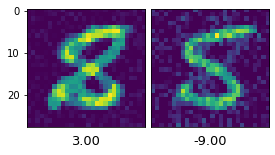

In [51]:
W = results_dict_new.get('loading')[0]
W_beta = results_dict_new.get('loading')[1]
display_dictionary_list2([W], grid_shape=[1,2], fig_size=[4,4], score_list = [W_beta[0][1:]]) # 2, 5

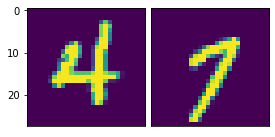

In [101]:
display_dictionary_list(W_true_Y, grid_shape=[1,2], fig_size=[4,4])

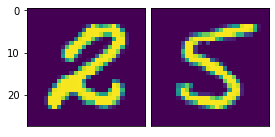

In [102]:
display_dictionary_list(W_true, grid_shape=[1,2], fig_size=[4,4])

In [59]:
d = {'AUC': results_dict_new.get('AUC'), 'Opt_threshold': results_dict_new.get('Training_threshold'), 'Accuracy': results_dict_new.get('Accuracy'), 'Sensitivity': results_dict_new.get('Sensitivity'), 'Specificity': results_dict_new.get('Specificity'), 'Precision': results_dict_new.get('Precision'), 'F_score': results_dict_new.get('F_score'), 'method': results_dict_new.get('method'), 'xi': xi_SNMF, 'Relative_reconstruction_loss (test)': results_dict_new.get('Relative_reconstruction_loss (test)')}
d2 = results_dict_list.copy()
d2.append(d)

In [61]:
d2

[{'AUC': 1.0,
  'Opt_threshold': 0.9599,
  'Accuracy': 0.8,
  'Sensitivity': 0.6778,
  'Specificity': 0.9,
  'Precision': 0.8472,
  'F_score': 0.7531,
  'method': 'LR',
  'xi': None,
  'Relative_reconstruction_loss (test)': 1},
 {'AUC': 0.9605,
  'Opt_threshold': 0.4403,
  'Accuracy': 0.88,
  'Sensitivity': 0.9111,
  'Specificity': 0.8545,
  'Precision': 0.8367,
  'F_score': 0.8723,
  'xi': None,
  'method': 'MF-->LR',
  'Relative_reconstruction_loss (test)': 0.8772233747973432},
 {'AUC': 0.9414,
  'Opt_threshold': 0.3782,
  'Accuracy': 0.85,
  'Sensitivity': 0.8444,
  'Specificity': 0.8545,
  'Precision': None,
  'F_score': 0.8351,
  'method': 'SDL-filt',
  'xi': 1,
  'Relative_reconstruction_loss (test)': 0.880131877591288}]

In [65]:
# LMF - feature-based

iteration1 = 200

# Cross-validation
xi_list = [0, 0.1, 1, 10]
beta_list = [1, None]
iter_avg = 2

LMF_AUC_array_naive = np.zeros(shape=[iter_avg, len(xi_list)])
LMF_AUC_array_exhaustive = np.zeros(shape=[iter_avg, len(xi_list)])
for beta in beta_list:
    for j in range(len(xi_list)):
        xi = xi_list[j]
        for i in range(iter_avg):
            LMF_class_new = LMF(X=[X_train, Y_train],  # data, label
                            X_test=[X_test, Y_test],
                            #X_auxiliary = None,
                            n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                            # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                            # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                            # ini_code = H_true, 
                            xi=xi,  # weight on label reconstruction error
                            L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                            L2_reg = [0,0,1], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                            nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                            full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

            results_dict_new = LMF_class_new.train_logistic(iter=iteration, subsample_size=None, 
                                                    beta = beta, 
                                                    search_radius_const=1000,
                                                    fine_tune_beta=True,
                                                    update_nuance_param=False,
                                                    if_compute_recons_error=False, if_validate=False)

            results_dict_new.update({'method': 'SDL-feat (naive)'})
            results_dict_new.update({'beta': beta})
            results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy (naive)')})
            results_dict_new.update({'F_score': results_dict_new.get('F_score (naive)')})
            results_dict_list.append(results_dict_new.copy())

            results_dict_new1 = results_dict_new.copy()
            results_dict_new1.update({'method': 'SDL-feat (exhaustive)'})
            results_dict_new1.update({'beta': beta})
            results_dict_new1.update({'Accuracy': results_dict_new1.get('Accuracy (exhaustive)')})
            results_dict_new1.update({'F_score': results_dict_new.get('F_score (exhaustive)')})
            results_dict_list.append(results_dict_new1.copy())

            LMF_AUC_array_naive[i,j] = results_dict_new.get('Accuracy (naive)') 
            LMF_AUC_array_exhaustive[i,j] = results_dict_new.get('Accuracy (exhaustive)') 

  0%|▏                                                    | 1/300 [00:00<00:47,  6.32it/s]

initial loading beta [[0.18417932 0.06942541 0.10424468]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 72.49it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [1.000, 0.906, 0.830]
!!! pred_type exhaustive


  2%|▊                                                    | 3/200 [00:00<00:07, 25.53it/s]

exhaustive prection..


  4%|██▏                                                | 13/300 [00:00<00:02, 127.58it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.017, 0.472, 0.515]
initial loading beta [[0.83419792 0.53033408 0.91279825]]


100%|███████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.78it/s]


!!! pred_type naive


  0%|                                                             | 0/200 [00:00<?, ?it/s]

--- Validation (naive) --- [threshold, AUC, accuracy] = [0.000, 0.766, 0.765]
!!! pred_type exhaustive
exhaustive prection..


 40%|████████████████████▌                               | 79/200 [00:02<00:03, 37.25it/s]C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\LMF.py:296: RuntimeWarning: invalid value encountered in double_scalars
  dist = np.linalg.norm(H1 - H1_old, 2) / np.linalg.norm(H1_old, 2)
  3%|█▋                                                  | 10/300 [00:00<00:03, 93.04it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.613, 0.511, 0.540]
initial loading beta [[0.47607931 0.10102684 0.16735193]]


100%|███████████████████████████████████████████████████| 300/300 [00:05<00:00, 52.00it/s]


!!! pred_type naive


  0%|                                                             | 0/200 [00:00<?, ?it/s]

--- Validation (naive) --- [threshold, AUC, accuracy] = [0.995, 0.945, 0.875]
!!! pred_type exhaustive
exhaustive prection..


  4%|██▏                                                | 13/300 [00:00<00:02, 127.66it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.002, 0.935, 0.670]
initial loading beta [[0.51104597 0.61557148 0.29576766]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 73.77it/s]


!!! pred_type naive


  0%|                                                             | 0/200 [00:00<?, ?it/s]

--- Validation (naive) --- [threshold, AUC, accuracy] = [0.939, 0.945, 0.860]
!!! pred_type exhaustive
exhaustive prection..


  4%|██                                                 | 12/300 [00:00<00:02, 115.01it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.003, 0.940, 0.690]
initial loading beta [[0.57595824 0.38909323 0.45605665]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 63.48it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.192, 0.956, 0.870]
!!! pred_type exhaustive


  2%|█                                                    | 4/200 [00:00<00:06, 31.52it/s]

exhaustive prection..


  3%|█▌                                                   | 9/300 [00:00<00:03, 86.71it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.000, 0.957, 0.885]
initial loading beta [[0.3335301  0.52806491 0.81480252]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 73.84it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.013, 0.956, 0.875]
!!! pred_type exhaustive


  2%|█▎                                                   | 5/200 [00:00<00:04, 42.75it/s]

exhaustive prection..


  3%|█▍                                                   | 8/300 [00:00<00:03, 75.58it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.000, 0.956, 0.870]
initial loading beta [[0.31705691 0.52311176 0.88965762]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 61.21it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.484, 0.867, 0.790]
!!! pred_type exhaustive


  3%|█▌                                                   | 6/200 [00:00<00:03, 56.09it/s]

exhaustive prection..


  3%|█▌                                                   | 9/300 [00:00<00:03, 88.69it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.048, 0.863, 0.795]
initial loading beta [[0.63381813 0.44795348 0.06450544]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 71.35it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.512, 0.944, 0.880]
!!! pred_type exhaustive


  6%|███                                                | 12/200 [00:00<00:01, 117.09it/s]

exhaustive prection..


  6%|███▎                                                | 19/300 [00:00<00:02, 94.68it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.019, 0.946, 0.890]
initial loading beta [[0.41042619 0.17391857 0.07496863]]


100%|███████████████████████████████████████████████████| 300/300 [00:03<00:00, 78.55it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.000, 0.738, 0.730]
!!! pred_type exhaustive


  4%|██                                                   | 8/200 [00:00<00:02, 78.52it/s]

exhaustive prection..


 42%|█████████████████████▌                              | 83/200 [00:01<00:02, 48.68it/s]C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\LMF.py:296: RuntimeWarning: invalid value encountered in double_scalars
  dist = np.linalg.norm(H1 - H1_old, 2) / np.linalg.norm(H1_old, 2)
  3%|█▋                                                  | 10/300 [00:00<00:02, 97.15it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.901, 0.459, 0.560]
initial loading beta [[0.7806385  0.3175477  0.04440717]]


100%|███████████████████████████████████████████████████| 300/300 [00:03<00:00, 76.94it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.000, 0.654, 0.665]
!!! pred_type exhaustive


  1%|▌                                                    | 2/200 [00:00<00:11, 17.10it/s]

exhaustive prection..


  9%|████▋                                               | 18/200 [00:00<00:06, 28.38it/s]C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\LMF.py:296: RuntimeWarning: invalid value encountered in double_scalars
  dist = np.linalg.norm(H1 - H1_old, 2) / np.linalg.norm(H1_old, 2)
  3%|█▌                                                   | 9/300 [00:00<00:03, 84.90it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.965, 0.488, 0.540]
initial loading beta [[0.61946203 0.68570076 0.84431204]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 63.52it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.833, 0.930, 0.845]
!!! pred_type exhaustive


  2%|█                                                    | 4/200 [00:00<00:05, 33.64it/s]

exhaustive prection..


  4%|██▏                                                | 13/300 [00:00<00:02, 125.54it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.000, 0.913, 0.640]
initial loading beta [[0.33429614 0.71215129 0.905703  ]]


100%|███████████████████████████████████████████████████| 300/300 [00:03<00:00, 81.86it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [1.000, 0.929, 0.860]
!!! pred_type exhaustive


  2%|█                                                    | 4/200 [00:00<00:06, 32.32it/s]

exhaustive prection..


  3%|█▌                                                   | 9/300 [00:00<00:03, 87.13it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.998, 0.948, 0.545]
initial loading beta [[0.38771935 0.34593404 0.95503129]]


100%|███████████████████████████████████████████████████| 300/300 [00:05<00:00, 51.08it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.107, 0.955, 0.890]
!!! pred_type exhaustive


  2%|█                                                    | 4/200 [00:00<00:05, 34.50it/s]

exhaustive prection..


  3%|█▌                                                   | 9/300 [00:00<00:03, 87.37it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.000, 0.954, 0.870]
initial loading beta [[0.09454373 0.1029885  0.51166652]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 63.13it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.275, 0.952, 0.880]
!!! pred_type exhaustive


  2%|█                                                    | 4/200 [00:00<00:05, 33.21it/s]

exhaustive prection..


  3%|█▋                                                  | 10/300 [00:00<00:03, 95.99it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.000, 0.953, 0.880]
initial loading beta [[0.4059787  0.96538187 0.18745063]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 71.07it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.504, 0.954, 0.875]
!!! pred_type exhaustive


  6%|██▊                                                 | 11/200 [00:00<00:01, 99.84it/s]

exhaustive prection..


  3%|█▍                                                   | 8/300 [00:00<00:04, 71.01it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.017, 0.956, 0.885]
initial loading beta [[0.67237203 0.78765799 0.3894869 ]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 72.96it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.520, 0.954, 0.875]
!!! pred_type exhaustive


  6%|██▊                                                | 11/200 [00:00<00:01, 102.37it/s]

exhaustive prection..


100%|███████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.07it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.014, 0.954, 0.885]


In [66]:
print(np.sum(LMF_AUC_array_naive, 0))        
xi_NMF_n = xi_list[np.argmax(np.sum(LMF_AUC_array_naive, 0))]
print(xi_NMF_n)

print(np.sum(LMF_AUC_array_exhaustive, 0))        
xi_NMF_e = xi_list[np.argmax(np.sum(LMF_AUC_array_exhaustive, 0))]
print(xi_NMF_e)



[1.395 1.705 1.77  1.75 ]
1
[1.1   1.185 1.75  1.77 ]
10


In [67]:
# Analysis
LMF_class_new = LMF(X=[X_train, Y_train],  # data, label
                        X_test=[X_test, Y_test],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true, 
                        xi=xi_NMF_e,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

results_dict_new = LMF_class_new.train_logistic(iter=iteration, subsample_size=None, 
                                        beta = beta, 
                                        search_radius_const=1000,
                                        fine_tune_beta=True,
                                        update_nuance_param=False,
                                        if_compute_recons_error=False, if_validate=False)

#results_dict_new.update({'xi': xi_NMF_e})
#results_dict_list.append(results_dict_new.copy())

  3%|█▋                                                  | 10/300 [00:00<00:03, 94.82it/s]

initial loading beta [[0.59985579 0.87379996 0.41604355]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 65.31it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.252, 0.958, 0.880]
!!! pred_type exhaustive


  4%|█▊                                                   | 7/200 [00:00<00:03, 62.75it/s]

exhaustive prection..


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 118.29it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.002, 0.958, 0.875]


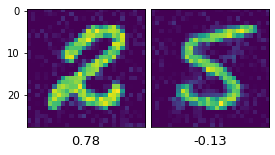

In [72]:
W = results_dict_new.get('loading')[0]
W_beta = results_dict_new.get('loading')[1]
display_dictionary_list2([W], grid_shape=[1,2], fig_size=[4,4], score_list = [W_beta[0][1:]]) # 2, 5

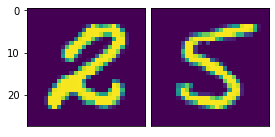

In [73]:
display_dictionary_list(W_true, grid_shape=[1,2], fig_size=[4,4])

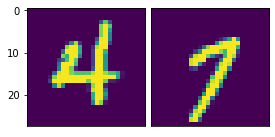

In [74]:
display_dictionary_list(W_true_Y, grid_shape=[1,2], fig_size=[4,4])

In [82]:
# Analysis
LMF_class_new = LMF(X=[X_train, Y_train],  # data, label
                        X_test=[X_test, Y_test],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        #ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_train, 
                        xi=xi_NMF_n,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

results_dict_new = LMF_class_new.train_logistic(iter=iteration, subsample_size=None, 
                                        beta = beta, 
                                        search_radius_const=1000,
                                        fine_tune_beta=True,
                                        update_nuance_param=False,
                                        if_compute_recons_error=False, if_validate=False)

#results_dict_new.update({'xi': xi_NMF_e})
#results_dict_list.append(results_dict_new.copy())

  3%|█▋                                                  | 10/300 [00:00<00:02, 98.89it/s]

initial loading beta [[0.98200751 0.12263158 0.48386269]]


100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 64.37it/s]


!!! pred_type naive
--- Validation (naive) --- [threshold, AUC, accuracy] = [0.226, 0.955, 0.875]
!!! pred_type exhaustive


  3%|█▌                                                   | 6/200 [00:00<00:03, 54.25it/s]

exhaustive prection..


100%|███████████████████████████████████████████████████| 200/200 [00:05<00:00, 36.72it/s]

--- Validation (exhaustive) --- [threshold, AUC, accuracy] = [0.000, 0.956, 0.875]


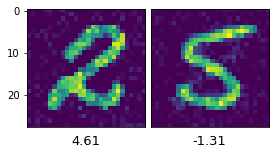

In [83]:
W = results_dict_new.get('loading')[0]
W_beta = results_dict_new.get('loading')[1]
display_dictionary_list2([W], grid_shape=[1,2], fig_size=[4,4], score_list = [W_beta[0][1:]]) # 2, 5

In [7]:
# SDL_SVP_filter

results_dict_list = []
r = 2*r0

iteration1 = 200

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

data_scale=10
for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SDL_SVP_class = SDL_SVP(X=[X_train/data_scale, Y_train],  # data, label
                                X_test=[X_test/data_scale, Y_test],
                                #X_auxiliary = None,
                                n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                                # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                                # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                                # ini_code = H_true,
                                xi=xi,  # weight on label reconstruction error
                                L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                                L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                                nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                                full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

        results_dict_new = SDL_SVP_class.fit(iter=iteration1, subsample_size=None,
                                                beta = 0,
                                                nu = 2,
                                                search_radius_const=0.05,
                                                update_nuance_param=False,
                                                SDL_option = 'filter',
                                                prediction_method_list = ['filter'],
                                                fine_tune_beta = False,
                                                if_compute_recons_error=True, if_validate=False)
        results_dict_new.update({'method': 'SDL-conv-filt'})
        results_dict_new.update({'beta': None})
        results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy (filter)')})
        results_dict_new.update({'F_score': results_dict_new.get('F_score (filter)')})
        results_dict_list.append(results_dict_new.copy())

# SDL_SVP_feature
data_scale=10
prediction_method_list = ['naive']
for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_SVP_class = SDL_SVP(X=[X_train/data_scale, Y_train],  # data, label
                                X_test=[X_test/data_scale, Y_test],
                                #X_auxiliary = None,
                                n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                                # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                                # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                                # ini_code = H_true,
                                xi=xi,  # weight on label reconstruction error
                                L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                                L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                                nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                                full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

        results_dict_new = SDL_SVP_class.fit(iter=iteration1, subsample_size=None,
                                            beta = 0,
                                            nu = 2,
                                            search_radius_const=0.01,
                                            update_nuance_param=False,
                                            SDL_option = 'feature',
                                            #prediction_method_list = ['naive', 'exhaustive'],
                                            prediction_method_list = prediction_method_list,
                                            fine_tune_beta = False,
                                            if_compute_recons_error=True, if_validate=False)

        for pred_type in prediction_method_list:
            results_dict_new.update({'method': 'SDL-conv-feat ({})'.format(str(pred_type))})
            results_dict_new.update({'beta': None})
            results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy ({})'.format(str(pred_type)))})
            results_dict_new.update({'F_score': results_dict_new.get('F_score ({})'.format(str(pred_type)))})
            results_dict_list.append(results_dict_new.copy())


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

initial loading beta [[ 0.54903179 -0.45629029  0.13759718]]
*** rel_error_data train 30.989713397339727


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:01<04:27,  1.35s/it]

~~~ rel_error_data train 0.984492139420924
--- Training --- [threshold, AUC] =  [1.0, 0.769]
--- Iteration 0: Training loss --- [Data, Label, Total] = [222144.245248.3, 5475.566534.3, 5475.566534.3]


  5%|████                                                                             | 10/200 [00:05<01:29,  2.13it/s]

*** rel_error_data train 30.97302753825249


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:06<02:15,  1.39it/s]

~~~ rel_error_data train 0.9841234546063563
--- Training --- [threshold, AUC] =  [1.0, 0.787]
--- Iteration 10: Training loss --- [Data, Label, Total] = [222024.635637.3, 6339.962189.3, 6339.962189.3]


 10%|████████                                                                         | 20/200 [00:15<02:59,  1.00it/s]

*** rel_error_data train 30.95343729092645


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:18<04:19,  1.45s/it]

~~~ rel_error_data train 0.9834809521012543
--- Training --- [threshold, AUC] =  [1.0, 0.801]
--- Iteration 20: Training loss --- [Data, Label, Total] = [221884.206435.3, 3585.435713.3, 3585.435713.3]


 15%|████████████▏                                                                    | 30/200 [00:29<03:30,  1.24s/it]

*** rel_error_data train 30.933265271596685


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:31<04:28,  1.59s/it]

~~~ rel_error_data train 0.9827453010877466
--- Training --- [threshold, AUC] =  [1.0, 0.83]
--- Iteration 30: Training loss --- [Data, Label, Total] = [221739.606905.3, 2220.816749.3, 2220.816749.3]


 20%|████████████████▏                                                                | 40/200 [00:38<02:06,  1.27it/s]

*** rel_error_data train 30.91631162118032


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [00:40<02:59,  1.13s/it]

~~~ rel_error_data train 0.9824662965895335
--- Training --- [threshold, AUC] =  [0.998, 0.873]
--- Iteration 40: Training loss --- [Data, Label, Total] = [221618.077679.3, 1529.850566.3, 1529.850566.3]


 25%|████████████████████▎                                                            | 50/200 [00:46<01:46,  1.41it/s]

*** rel_error_data train 30.9039389849159


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [00:48<03:21,  1.35s/it]

~~~ rel_error_data train 0.982631228655954
--- Training --- [threshold, AUC] =  [0.954, 0.918]
--- Iteration 50: Training loss --- [Data, Label, Total] = [221529.386638.3, 744.586851.3, 744.586851.3]


 30%|████████████████████████▎                                                        | 60/200 [00:56<01:51,  1.26it/s]

*** rel_error_data train 30.900576731252876


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [00:58<02:27,  1.06s/it]

~~~ rel_error_data train 0.9828772333942298
--- Training --- [threshold, AUC] =  [0.898, 0.949]
--- Iteration 60: Training loss --- [Data, Label, Total] = [221505.284921.3, 409.684845.3, 409.684845.3]


 35%|████████████████████████████▎                                                    | 70/200 [01:05<02:05,  1.03it/s]

*** rel_error_data train 30.88893140571785


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [01:08<03:24,  1.58s/it]

~~~ rel_error_data train 0.9825056751179415
--- Training --- [threshold, AUC] =  [1.0, 0.964]
--- Iteration 70: Training loss --- [Data, Label, Total] = [221421.807477.3, 1229.410848.3, 1229.410848.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:16<01:35,  1.25it/s]

*** rel_error_data train 30.86930177082956


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:18<02:14,  1.13s/it]

~~~ rel_error_data train 0.982477282932163
--- Training --- [threshold, AUC] =  [0.679, 0.98]
--- Iteration 80: Training loss --- [Data, Label, Total] = [221281.095933.3, 188.097934.3, 188.097934.3]


 45%|████████████████████████████████████▍                                            | 90/200 [01:26<01:38,  1.12it/s]

*** rel_error_data train 30.868923991091528


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [01:28<02:18,  1.27s/it]

~~~ rel_error_data train 0.9825698889333879
--- Training --- [threshold, AUC] =  [0.341, 0.988]
--- Iteration 90: Training loss --- [Data, Label, Total] = [221278.387886.3, 121.732692.3, 121.732692.3]


 50%|████████████████████████████████████████                                        | 100/200 [01:36<01:30,  1.11it/s]

*** rel_error_data train 30.86860293130292


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [01:39<02:21,  1.43s/it]

~~~ rel_error_data train 0.982592225106204
--- Training --- [threshold, AUC] =  [0.49, 0.993]
--- Iteration 100: Training loss --- [Data, Label, Total] = [221276.086426.3, 87.359051.3, 87.359051.3]


 55%|████████████████████████████████████████████                                    | 110/200 [01:47<01:31,  1.02s/it]

*** rel_error_data train 30.868363577534385


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [01:51<02:27,  1.66s/it]

~~~ rel_error_data train 0.9825943287773224
--- Training --- [threshold, AUC] =  [0.506, 0.996]
--- Iteration 110: Training loss --- [Data, Label, Total] = [221274.370662.3, 66.086037.3, 66.086037.3]


 60%|████████████████████████████████████████████████                                | 120/200 [02:01<01:24,  1.06s/it]

*** rel_error_data train 30.868192069816537


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [02:04<02:11,  1.67s/it]

~~~ rel_error_data train 0.9825876173965682
--- Training --- [threshold, AUC] =  [0.542, 0.998]
--- Iteration 120: Training loss --- [Data, Label, Total] = [221273.141239.3, 51.728787.3, 51.728787.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [02:18<01:34,  1.35s/it]

*** rel_error_data train 30.86806861962058


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [02:21<02:05,  1.82s/it]

~~~ rel_error_data train 0.9825765169816332
--- Training --- [threshold, AUC] =  [0.481, 0.999]
--- Iteration 130: Training loss --- [Data, Label, Total] = [221272.256308.3, 41.636520.3, 41.636520.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [02:33<01:22,  1.37s/it]

*** rel_error_data train 30.867975485751664


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [02:36<01:53,  1.92s/it]

~~~ rel_error_data train 0.9825638262331396
--- Training --- [threshold, AUC] =  [0.607, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [221271.588695.3, 34.528989.3, 34.528989.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [02:45<00:46,  1.07it/s]

*** rel_error_data train 30.867899688561824


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [02:47<01:03,  1.30s/it]

~~~ rel_error_data train 0.9825512402535254
--- Training --- [threshold, AUC] =  [0.52, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [221271.045356.3, 29.526716.3, 29.526716.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [02:54<00:31,  1.29it/s]

*** rel_error_data train 30.867834409776133


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [02:56<00:43,  1.12s/it]

~~~ rel_error_data train 0.9825393088904759
--- Training --- [threshold, AUC] =  [0.487, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [221270.577417.3, 25.898371.3, 25.898371.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [03:02<00:22,  1.35it/s]

*** rel_error_data train 30.867776727848486


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [03:04<00:29,  1.03s/it]

~~~ rel_error_data train 0.9825281497761087
--- Training --- [threshold, AUC] =  [0.581, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [221270.163934.3, 23.140101.3, 23.140101.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [03:11<00:15,  1.26it/s]

*** rel_error_data train 30.867725136453018


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [03:13<00:22,  1.20s/it]

~~~ rel_error_data train 0.9825177707995691
--- Training --- [threshold, AUC] =  [0.647, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [221269.794110.3, 20.954299.3, 20.954299.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [03:20<00:08,  1.24it/s]

*** rel_error_data train 30.867678589839162


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [03:22<00:10,  1.18s/it]

~~~ rel_error_data train 0.9825081295553716
--- Training --- [threshold, AUC] =  [0.695, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [221269.460449.3, 19.167340.3, 19.167340.3]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.728, 1.0]
!!! ACC_list [0.845]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.971, 0.916, 0.845, 0.984]
initial loading beta [[ 0.43476056 -0.22125326  0.65799314]]
*** rel_error_data train 30.396071290893875


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:02<06:38,  2.00s/it]

~~~ rel_error_data train 0.9844685826704179
--- Training --- [threshold, AUC] =  [0.0, 0.499]
--- Iteration 0: Training loss --- [Data, Label, Total] = [217888.827459.3, 6805.937384.3, 6805.937384.3]


  5%|████                                                                             | 10/200 [00:09<02:37,  1.21it/s]

*** rel_error_data train 30.374678626548455


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:11<03:55,  1.25s/it]

~~~ rel_error_data train 0.9838809277622269
--- Training --- [threshold, AUC] =  [0.001, 0.783]
--- Iteration 10: Training loss --- [Data, Label, Total] = [217735.477952.3, 2251.756905.3, 2251.756905.3]


 10%|████████                                                                         | 20/200 [00:18<02:25,  1.24it/s]

*** rel_error_data train 30.347756352247448


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:20<03:36,  1.21s/it]

~~~ rel_error_data train 0.9828985775373306
--- Training --- [threshold, AUC] =  [0.002, 0.817]
--- Iteration 20: Training loss --- [Data, Label, Total] = [217542.490420.3, 2115.730301.3, 2115.730301.3]


 15%|████████████▏                                                                    | 30/200 [00:28<02:35,  1.09it/s]

*** rel_error_data train 30.32499339137604


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:31<04:01,  1.43s/it]

~~~ rel_error_data train 0.9823240873442316
--- Training --- [threshold, AUC] =  [0.0, 0.866]
--- Iteration 30: Training loss --- [Data, Label, Total] = [217379.318186.3, 1462.698283.3, 1462.698283.3]


 20%|████████████████▏                                                                | 40/200 [00:38<02:11,  1.22it/s]

*** rel_error_data train 30.30919511609479


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [00:40<03:00,  1.14s/it]

~~~ rel_error_data train 0.9823389177224202
--- Training --- [threshold, AUC] =  [0.005, 0.917]
--- Iteration 40: Training loss --- [Data, Label, Total] = [217266.071061.3, 988.680377.3, 988.680377.3]


 25%|████████████████████▎                                                            | 50/200 [00:46<01:49,  1.37it/s]

*** rel_error_data train 30.299319747953056


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [00:48<02:40,  1.08s/it]

~~~ rel_error_data train 0.982440826069083
--- Training --- [threshold, AUC] =  [0.04, 0.95]
--- Iteration 50: Training loss --- [Data, Label, Total] = [217195.281242.3, 548.985021.3, 548.985021.3]


 30%|████████████████████████▎                                                        | 60/200 [00:56<02:01,  1.15it/s]

*** rel_error_data train 30.2953660215627


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [00:58<02:43,  1.18s/it]

~~~ rel_error_data train 0.9825491257005611
--- Training --- [threshold, AUC] =  [0.035, 0.969]
--- Iteration 60: Training loss --- [Data, Label, Total] = [217166.939658.3, 308.127094.3, 308.127094.3]


 35%|████████████████████████████▎                                                    | 70/200 [01:04<01:36,  1.35it/s]

*** rel_error_data train 30.292788673354707


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [01:06<02:20,  1.09s/it]

~~~ rel_error_data train 0.9826279086678407
--- Training --- [threshold, AUC] =  [0.088, 0.98]
--- Iteration 70: Training loss --- [Data, Label, Total] = [217148.464396.3, 258.634342.3, 258.634342.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:12<01:26,  1.39it/s]

*** rel_error_data train 30.2883748540031


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:15<02:47,  1.40s/it]

~~~ rel_error_data train 0.9825985810830835
--- Training --- [threshold, AUC] =  [0.033, 0.987]
--- Iteration 80: Training loss --- [Data, Label, Total] = [217116.824718.3, 229.860841.3, 229.860841.3]


 45%|████████████████████████████████████▍                                            | 90/200 [01:23<01:29,  1.23it/s]

*** rel_error_data train 30.28638506320127


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [01:27<03:23,  1.86s/it]

~~~ rel_error_data train 0.9824996717502129
--- Training --- [threshold, AUC] =  [0.399, 0.992]
--- Iteration 90: Training loss --- [Data, Label, Total] = [217102.561256.3, 92.734144.3, 92.734144.3]


 50%|████████████████████████████████████████                                        | 100/200 [01:35<01:21,  1.22it/s]

*** rel_error_data train 30.286297839173834


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [01:37<02:01,  1.23s/it]

~~~ rel_error_data train 0.9825033485856633
--- Training --- [threshold, AUC] =  [0.538, 0.996]
--- Iteration 100: Training loss --- [Data, Label, Total] = [217101.936006.3, 66.892785.3, 66.892785.3]


 55%|████████████████████████████████████████████                                    | 110/200 [01:45<01:22,  1.08it/s]

*** rel_error_data train 30.28625036635314


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [01:48<02:13,  1.50s/it]

~~~ rel_error_data train 0.9825084412912082
--- Training --- [threshold, AUC] =  [0.653, 0.998]
--- Iteration 110: Training loss --- [Data, Label, Total] = [217101.595706.3, 50.993531.3, 50.993531.3]


 60%|████████████████████████████████████████████████                                | 120/200 [01:56<01:11,  1.11it/s]

*** rel_error_data train 30.286202048928715


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [01:59<01:45,  1.34s/it]

~~~ rel_error_data train 0.9825055970239295
--- Training --- [threshold, AUC] =  [0.485, 0.999]
--- Iteration 120: Training loss --- [Data, Label, Total] = [217101.249351.3, 40.344597.3, 40.344597.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [02:06<01:00,  1.16it/s]

*** rel_error_data train 30.286156620737028


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [02:09<01:30,  1.31s/it]

~~~ rel_error_data train 0.9824967450228127
--- Training --- [threshold, AUC] =  [0.542, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [217100.923707.3, 33.361396.3, 33.361396.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [02:15<00:44,  1.36it/s]

*** rel_error_data train 30.28611590657206


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [02:17<01:03,  1.08s/it]

~~~ rel_error_data train 0.9824847127141905
--- Training --- [threshold, AUC] =  [0.486, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [217100.631855.3, 28.638282.3, 28.638282.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [02:23<00:34,  1.46it/s]

*** rel_error_data train 30.286080530344332


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [02:25<00:52,  1.07s/it]

~~~ rel_error_data train 0.9824717267767616
--- Training --- [threshold, AUC] =  [0.575, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [217100.378267.3, 25.230313.3, 25.230313.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [02:31<00:26,  1.54it/s]

*** rel_error_data train 30.286049988878744


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [02:33<00:35,  1.09it/s]

~~~ rel_error_data train 0.9824589136676767
--- Training --- [threshold, AUC] =  [0.643, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [217100.159336.3, 22.626728.3, 22.626728.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [02:37<00:16,  1.87it/s]

*** rel_error_data train 30.286023407910914


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [02:39<00:24,  1.17it/s]

~~~ rel_error_data train 0.9824467168838128
--- Training --- [threshold, AUC] =  [0.695, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [217099.968795.3, 20.553072.3, 20.553072.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [02:44<00:10,  1.85it/s]

*** rel_error_data train 30.285999980071292


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [02:45<00:15,  1.25it/s]

~~~ rel_error_data train 0.9824352683188844
--- Training --- [threshold, AUC] =  [0.734, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [217099.800856.3, 18.851168.3, 18.851168.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [02:50<00:05,  1.69it/s]

*** rel_error_data train 30.2859790696936


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [02:52<00:08,  1.12it/s]

~~~ rel_error_data train 0.9824245717878072
--- Training --- [threshold, AUC] =  [0.765, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [217099.650964.3, 17.422822.3, 17.422822.3]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.787, 1.0]
!!! ACC_list [0.79]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.248, 0.903, 0.790, 0.984]
initial loading beta [[0.38241114 0.85894763 0.99732217]]
*** rel_error_data train 27.754829091533402


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:01<05:16,  1.59s/it]

~~~ rel_error_data train 0.9859814496665564
--- Training --- [threshold, AUC] =  [0.0, 0.777]
--- Iteration 0: Training loss --- [Data, Label, Total] = [198955.552815.3, 2961.487750.3, 22857.043032.3]


  5%|████                                                                             | 10/200 [00:08<02:14,  1.41it/s]

*** rel_error_data train 22.849364508494745


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:09<03:05,  1.02it/s]

~~~ rel_error_data train 0.98540520271997
--- Training --- [threshold, AUC] =  [0.0, 0.785]
--- Iteration 10: Training loss --- [Data, Label, Total] = [163791.602977.3, 2281.885876.3, 18661.046174.3]


 10%|████████                                                                         | 20/200 [00:15<02:03,  1.46it/s]

*** rel_error_data train 18.838865645468108


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:17<02:53,  1.03it/s]

~~~ rel_error_data train 0.9848130552575453
--- Training --- [threshold, AUC] =  [0.001, 0.805]
--- Iteration 20: Training loss --- [Data, Label, Total] = [135043.055626.3, 1967.427567.3, 15471.733129.3]


 15%|████████████▏                                                                    | 30/200 [00:23<02:05,  1.36it/s]

*** rel_error_data train 15.552889348319926


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:25<02:41,  1.05it/s]

~~~ rel_error_data train 0.9840970728293251
--- Training --- [threshold, AUC] =  [0.001, 0.858]
--- Iteration 30: Training loss --- [Data, Label, Total] = [111488.119345.3, 1709.219256.3, 12858.031190.3]


 20%|████████████████▏                                                                | 40/200 [00:31<01:53,  1.40it/s]

*** rel_error_data train 12.857884666574437


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [00:33<02:35,  1.02it/s]

~~~ rel_error_data train 0.9831583458183486
--- Training --- [threshold, AUC] =  [0.003, 0.928]
--- Iteration 40: Training loss --- [Data, Label, Total] = [92169.457914.3, 915.912701.3, 10132.858492.3]


 25%|████████████████████▎                                                            | 50/200 [00:40<02:07,  1.18it/s]

*** rel_error_data train 10.673716942473852


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [00:41<02:39,  1.07s/it]

~~~ rel_error_data train 0.9825348525080452
--- Training --- [threshold, AUC] =  [0.032, 0.966]
--- Iteration 50: Training loss --- [Data, Label, Total] = [76512.640300.3, 399.803933.3, 8051.067963.3]


 30%|████████████████████████▎                                                        | 60/200 [00:47<01:34,  1.48it/s]

*** rel_error_data train 8.884540958984337


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [00:49<02:12,  1.05it/s]

~~~ rel_error_data train 0.9818628568463513
--- Training --- [threshold, AUC] =  [0.002, 0.985]
--- Iteration 60: Training loss --- [Data, Label, Total] = [63687.250682.3, 565.210729.3, 6933.935797.3]


 35%|████████████████████████████▎                                                    | 70/200 [00:56<01:37,  1.34it/s]

*** rel_error_data train 7.423055541130927


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [00:57<02:12,  1.03s/it]

~~~ rel_error_data train 0.9813057146012093
--- Training --- [threshold, AUC] =  [0.295, 0.992]
--- Iteration 70: Training loss --- [Data, Label, Total] = [53210.852565.3, 98.170462.3, 5419.255718.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:03<01:27,  1.38it/s]

*** rel_error_data train 6.234631382636802


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:05<02:07,  1.07s/it]

~~~ rel_error_data train 0.9807933191676219
--- Training --- [threshold, AUC] =  [0.562, 0.998]
--- Iteration 80: Training loss --- [Data, Label, Total] = [44691.845489.3, 50.199025.3, 4519.383574.3]


 45%|████████████████████████████████████▍                                            | 90/200 [01:12<01:15,  1.45it/s]

*** rel_error_data train 5.262464944567007


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [01:13<01:48,  1.00it/s]

~~~ rel_error_data train 0.9802151422845559
--- Training --- [threshold, AUC] =  [0.575, 0.999]
--- Iteration 90: Training loss --- [Data, Label, Total] = [37723.043394.3, 30.022171.3, 3802.326511.3]


 50%|████████████████████████████████████████                                        | 100/200 [01:20<01:23,  1.19it/s]

*** rel_error_data train 4.467204412716535


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [01:22<01:50,  1.12s/it]

~~~ rel_error_data train 0.9795613786371378
--- Training --- [threshold, AUC] =  [0.665, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [32022.359804.3, 20.784795.3, 3223.020775.3]


 55%|████████████████████████████████████████████                                    | 110/200 [01:28<01:05,  1.38it/s]

*** rel_error_data train 3.8166473034550994


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [01:30<01:26,  1.03it/s]

~~~ rel_error_data train 0.9788265573606373
--- Training --- [threshold, AUC] =  [0.578, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [27358.956946.3, 16.366687.3, 2752.262382.3]


 60%|████████████████████████████████████████████████                                | 120/200 [01:36<00:55,  1.43it/s]

*** rel_error_data train 3.28442846259985


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [01:38<01:27,  1.10s/it]

~~~ rel_error_data train 0.9780074642458018
--- Training --- [threshold, AUC] =  [0.734, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [23543.840904.3, 13.864878.3, 2368.248969.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [01:44<00:51,  1.35it/s]

*** rel_error_data train 2.8489829059969125


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [01:46<01:10,  1.02s/it]

~~~ rel_error_data train 0.9771001517604772
--- Training --- [threshold, AUC] =  [0.806, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [20422.426928.3, 12.173831.3, 2054.416524.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [01:52<00:41,  1.46it/s]

*** rel_error_data train 2.4926757199789797


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [01:54<00:57,  1.03it/s]

~~~ rel_error_data train 0.9760993018232349
--- Training --- [threshold, AUC] =  [0.846, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [17868.302277.3, 10.920160.3, 1797.750388.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [02:00<00:35,  1.42it/s]

*** rel_error_data train 2.20108429945508


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [02:02<00:48,  1.01it/s]

~~~ rel_error_data train 0.9749993534256476
--- Training --- [threshold, AUC] =  [0.871, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [15778.081074.3, 9.939629.3, 1587.747736.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [02:08<00:34,  1.16it/s]

*** rel_error_data train 1.9624131273901784


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [02:11<00:52,  1.34s/it]

~~~ rel_error_data train 0.9737952415147452
--- Training --- [threshold, AUC] =  [0.886, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [14067.209253.3, 9.145039.3, 1415.865964.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [02:19<00:28,  1.05it/s]

*** rel_error_data train 1.767015602647769


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [02:21<00:41,  1.42s/it]

~~~ rel_error_data train 0.9724829903990106
--- Training --- [threshold, AUC] =  [0.895, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [12666.536872.3, 8.484504.3, 1275.138191.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [02:28<00:14,  1.36it/s]

*** rel_error_data train 1.6070030860322557


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [02:30<00:18,  1.01it/s]

~~~ rel_error_data train 0.9710603066899303
--- Training --- [threshold, AUC] =  [0.903, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [11519.515624.3, 7.924675.3, 1159.876237.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [02:36<00:07,  1.29it/s]

*** rel_error_data train 1.4759252043434483


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [02:38<00:10,  1.13s/it]

~~~ rel_error_data train 0.9695271995504988
--- Training --- [threshold, AUC] =  [0.91, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [10579.907157.3, 7.442880.3, 1065.433595.3]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.915, 1.0]
!!! ACC_list [0.865]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.323, 0.921, 0.865, 0.971]
initial loading beta [[-0.94378287 -0.72423462  0.66614286]]
*** rel_error_data train 30.646599496961294


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:02<07:04,  2.13s/it]

~~~ rel_error_data train 0.9846811168701302
--- Training --- [threshold, AUC] =  [1.0, 0.734]
--- Iteration 0: Training loss --- [Data, Label, Total] = [219684.694317.3, 5866.757835.3, 27835.227266.3]


  5%|████                                                                             | 10/200 [00:10<03:14,  1.03s/it]

*** rel_error_data train 25.20766031153917


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:12<03:53,  1.23s/it]

~~~ rel_error_data train 0.9839070581308365
--- Training --- [threshold, AUC] =  [1.0, 0.781]
--- Iteration 10: Training loss --- [Data, Label, Total] = [180696.626735.3, 5121.997513.3, 23191.660187.3]


 10%|████████                                                                         | 20/200 [00:18<01:56,  1.55it/s]

*** rel_error_data train 20.741032373262843


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:20<02:51,  1.05it/s]

~~~ rel_error_data train 0.981205629653596
--- Training --- [threshold, AUC] =  [1.0, 0.83]
--- Iteration 20: Training loss --- [Data, Label, Total] = [148678.399285.3, 4009.216270.3, 18877.056199.3]


 15%|████████████▏                                                                    | 30/200 [00:26<01:56,  1.46it/s]

*** rel_error_data train 17.093170502873804


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:28<03:15,  1.15s/it]

~~~ rel_error_data train 0.9799612365330737
--- Training --- [threshold, AUC] =  [1.0, 0.901]
--- Iteration 30: Training loss --- [Data, Label, Total] = [122529.350678.3, 1647.927673.3, 13900.862741.3]


 20%|████████████████▏                                                                | 40/200 [00:34<02:05,  1.28it/s]

*** rel_error_data train 14.133633138203612


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [00:36<02:34,  1.03it/s]

~~~ rel_error_data train 0.9809079911478433
--- Training --- [threshold, AUC] =  [0.93, 0.953]
--- Iteration 40: Training loss --- [Data, Label, Total] = [101314.433788.3, 411.174663.3, 10542.618042.3]


 25%|████████████████████▎                                                            | 50/200 [00:42<01:43,  1.46it/s]

*** rel_error_data train 11.718952428747574


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [00:44<02:26,  1.02it/s]

~~~ rel_error_data train 0.9805426729574159
--- Training --- [threshold, AUC] =  [0.996, 0.976]
--- Iteration 50: Training loss --- [Data, Label, Total] = [84005.224863.3, 563.831312.3, 8964.353798.3]


 30%|████████████████████████▎                                                        | 60/200 [00:49<01:30,  1.54it/s]

*** rel_error_data train 9.730508711825708


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [00:51<02:07,  1.09it/s]

~~~ rel_error_data train 0.9796964005394968
--- Training --- [threshold, AUC] =  [0.944, 0.988]
--- Iteration 60: Training loss --- [Data, Label, Total] = [69751.419962.3, 233.073565.3, 7208.215561.3]


 35%|████████████████████████████▎                                                    | 70/200 [00:56<01:25,  1.53it/s]

*** rel_error_data train 8.121652906573644


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [00:58<02:03,  1.04it/s]

~~~ rel_error_data train 0.9797754141659192
--- Training --- [threshold, AUC] =  [0.599, 0.996]
--- Iteration 70: Training loss --- [Data, Label, Total] = [58218.623450.3, 59.536159.3, 5881.398504.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:04<01:20,  1.50it/s]

*** rel_error_data train 6.805680463806805


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:06<01:59,  1.01s/it]

~~~ rel_error_data train 0.9793701942808769
--- Training --- [threshold, AUC] =  [0.599, 0.999]
--- Iteration 80: Training loss --- [Data, Label, Total] = [48785.309198.3, 31.927686.3, 4910.458606.3]


 45%|████████████████████████████████████▍                                            | 90/200 [01:12<01:19,  1.38it/s]

*** rel_error_data train 5.729250465417362


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [01:14<01:53,  1.04s/it]

~~~ rel_error_data train 0.9788520479341617
--- Training --- [threshold, AUC] =  [0.543, 1.0]
--- Iteration 90: Training loss --- [Data, Label, Total] = [41069.112326.3, 20.260457.3, 4127.171689.3]


 50%|████████████████████████████████████████                                        | 100/200 [01:20<01:16,  1.30it/s]

*** rel_error_data train 4.84872391893204


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [01:23<01:59,  1.20s/it]

~~~ rel_error_data train 0.9782447317747895
--- Training --- [threshold, AUC] =  [0.721, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [34757.214485.3, 15.369171.3, 3491.090619.3]


 55%|████████████████████████████████████████████                                    | 110/200 [01:29<01:00,  1.48it/s]

*** rel_error_data train 4.128422052933464


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [01:30<01:29,  1.00s/it]

~~~ rel_error_data train 0.9775610475418413
--- Training --- [threshold, AUC] =  [0.783, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [29593.858751.3, 12.765162.3, 2972.151037.3]


 60%|████████████████████████████████████████████████                                | 120/200 [01:36<00:53,  1.49it/s]

*** rel_error_data train 3.539162453680517


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [01:38<01:13,  1.07it/s]

~~~ rel_error_data train 0.9768016167755565
--- Training --- [threshold, AUC] =  [0.821, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [25369.856184.3, 11.053582.3, 2548.039200.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [01:43<00:47,  1.46it/s]

*** rel_error_data train 3.057074841284238


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [01:45<01:07,  1.02it/s]

~~~ rel_error_data train 0.975962585373773
--- Training --- [threshold, AUC] =  [0.846, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [21914.096932.3, 9.813781.3, 2201.223474.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [01:51<00:40,  1.48it/s]

*** rel_error_data train 2.662634797705683


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [01:53<00:58,  1.02it/s]

~~~ rel_error_data train 0.9750389717302943
--- Training --- [threshold, AUC] =  [0.864, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [19086.623678.3, 8.864053.3, 1917.526421.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [01:59<00:36,  1.37it/s]

*** rel_error_data train 2.3398729149273985


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [02:01<00:49,  1.02s/it]

~~~ rel_error_data train 0.9740256313778246
--- Training --- [threshold, AUC] =  [0.879, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [16772.962563.3, 8.108518.3, 1685.404774.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [02:07<00:29,  1.37it/s]

*** rel_error_data train 2.0757278249433075


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [02:09<00:42,  1.09s/it]

~~~ rel_error_data train 0.9729177800959817
--- Training --- [threshold, AUC] =  [0.89, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [14879.485496.3, 7.490533.3, 1495.439083.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [02:15<00:21,  1.42it/s]

*** rel_error_data train 1.8595170198402715


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [02:17<00:29,  1.00s/it]

~~~ rel_error_data train 0.9717114451200033
--- Training --- [threshold, AUC] =  [0.899, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [13329.616818.3, 6.974057.3, 1339.935739.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [02:23<00:13,  1.44it/s]

*** rel_error_data train 1.6825040474484823


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [02:25<00:19,  1.01s/it]

~~~ rel_error_data train 0.9704039341937005
--- Training --- [threshold, AUC] =  [0.906, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [12060.730829.3, 6.534895.3, 1212.607978.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [02:31<00:07,  1.39it/s]

*** rel_error_data train 1.5375445400797816


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [02:33<00:09,  1.04s/it]

~~~ rel_error_data train 0.9689943409027473
--- Training --- [threshold, AUC] =  [0.913, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [11021.614399.3, 6.156128.3, 1108.317567.3]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.918, 1.0]
!!! ACC_list [0.815]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.158, 0.922, 0.815, 0.970]
initial loading beta [[ 0.71302313  0.92657262 -0.94236056]]
*** rel_error_data train 23.937904744538386


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:02<06:42,  2.02s/it]

~~~ rel_error_data train 0.9848968908609509
--- Training --- [threshold, AUC] =  [0.008, 0.434]
--- Iteration 0: Training loss --- [Data, Label, Total] = [171594.609931.3, 2741.351395.3, 174335.961326.3]


  5%|████                                                                             | 10/200 [00:09<02:48,  1.13it/s]

*** rel_error_data train 3.6687166337906243


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:11<03:59,  1.27s/it]

~~~ rel_error_data train 0.9786537579158927
--- Training --- [threshold, AUC] =  [0.0, 0.922]
--- Iteration 10: Training loss --- [Data, Label, Total] = [26298.542268.3, 5366.735146.3, 31665.277413.3]


 10%|████████                                                                         | 20/200 [00:19<02:35,  1.16it/s]

*** rel_error_data train 1.2202472248988638


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:21<03:44,  1.26s/it]

~~~ rel_error_data train 0.9630594719173244
--- Training --- [threshold, AUC] =  [0.007, 0.977]
--- Iteration 20: Training loss --- [Data, Label, Total] = [8747.125064.3, 452.973352.3, 9200.098417.3]


 15%|████████████▏                                                                    | 30/200 [00:29<02:31,  1.12it/s]

*** rel_error_data train 0.9177212239491972


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:31<03:28,  1.23s/it]

~~~ rel_error_data train 0.9446886890857121
--- Training --- [threshold, AUC] =  [0.305, 0.993]
--- Iteration 30: Training loss --- [Data, Label, Total] = [6578.521267.3, 101.219641.3, 6679.740908.3]


 20%|████████████████▏                                                                | 40/200 [00:38<02:11,  1.22it/s]

*** rel_error_data train 0.8785913472344606


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [00:40<03:04,  1.16s/it]

~~~ rel_error_data train 0.9361366278431511
--- Training --- [threshold, AUC] =  [0.355, 0.998]
--- Iteration 40: Training loss --- [Data, Label, Total] = [6298.025710.3, 42.918143.3, 6340.943853.3]


 25%|████████████████████▎                                                            | 50/200 [00:48<02:30,  1.01s/it]

*** rel_error_data train 0.8736137731385578


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [00:51<03:34,  1.44s/it]

~~~ rel_error_data train 0.9345358655265035
--- Training --- [threshold, AUC] =  [0.564, 1.0]
--- Iteration 50: Training loss --- [Data, Label, Total] = [6262.344856.3, 24.069149.3, 6286.414004.3]


 30%|████████████████████████▎                                                        | 60/200 [00:58<01:52,  1.24it/s]

*** rel_error_data train 0.8729855444966983


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [01:00<02:27,  1.06s/it]

~~~ rel_error_data train 0.9343180510435057
--- Training --- [threshold, AUC] =  [0.624, 1.0]
--- Iteration 60: Training loss --- [Data, Label, Total] = [6257.841510.3, 17.416862.3, 6275.258373.3]


 35%|████████████████████████████▎                                                    | 70/200 [01:06<01:37,  1.33it/s]

*** rel_error_data train 0.8729041864892746


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [01:08<02:14,  1.04s/it]

~~~ rel_error_data train 0.9342903341800236
--- Training --- [threshold, AUC] =  [0.733, 1.0]
--- Iteration 70: Training loss --- [Data, Label, Total] = [6257.258310.3, 14.340070.3, 6271.598380.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:15<01:27,  1.37it/s]

*** rel_error_data train 0.8728890422761072


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:16<02:07,  1.07s/it]

~~~ rel_error_data train 0.9342846277826392
--- Training --- [threshold, AUC] =  [0.787, 1.0]
--- Iteration 80: Training loss --- [Data, Label, Total] = [6257.149751.3, 12.453927.3, 6269.603678.3]


 45%|████████████████████████████████████▍                                            | 90/200 [01:23<01:26,  1.27it/s]

*** rel_error_data train 0.8728791637185322


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [01:25<01:51,  1.02s/it]

~~~ rel_error_data train 0.9342797724768842
--- Training --- [threshold, AUC] =  [0.818, 1.0]
--- Iteration 90: Training loss --- [Data, Label, Total] = [6257.078939.3, 11.139061.3, 6268.218000.3]


 50%|████████████████████████████████████████                                        | 100/200 [01:31<01:20,  1.25it/s]

*** rel_error_data train 0.8728675709202355


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [01:33<01:47,  1.09s/it]

~~~ rel_error_data train 0.9342736753983404
--- Training --- [threshold, AUC] =  [0.839, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [6256.995838.3, 10.156071.3, 6267.151909.3]


 55%|████████████████████████████████████████████                                    | 110/200 [01:43<01:27,  1.03it/s]

*** rel_error_data train 0.8728540762689375


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [01:45<02:00,  1.36s/it]

~~~ rel_error_data train 0.9342664946633542
--- Training --- [threshold, AUC] =  [0.854, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [6256.899104.3, 9.387300.3, 6266.286403.3]


 60%|████████████████████████████████████████████████                                | 120/200 [01:54<01:14,  1.07it/s]

*** rel_error_data train 0.8728391573341373


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [01:56<01:44,  1.33s/it]

~~~ rel_error_data train 0.9342585326881445
--- Training --- [threshold, AUC] =  [0.866, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [6256.792160.3, 8.766636.3, 6265.558796.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [02:04<01:03,  1.11it/s]

*** rel_error_data train 0.8728232245942286


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [02:07<01:32,  1.33s/it]

~~~ rel_error_data train 0.9342500200822744
--- Training --- [threshold, AUC] =  [0.875, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [6256.677949.3, 8.253501.3, 6264.931450.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [02:15<00:54,  1.10it/s]

*** rel_error_data train 0.8728065791553044


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [02:18<01:28,  1.50s/it]

~~~ rel_error_data train 0.9342411216304127
--- Training --- [threshold, AUC] =  [0.882, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [6256.558629.3, 7.821353.3, 6264.379982.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [02:27<00:55,  1.11s/it]

*** rel_error_data train 0.872789441228624


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [02:29<01:17,  1.59s/it]

~~~ rel_error_data train 0.9342319568413903
--- Training --- [threshold, AUC] =  [0.888, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [6256.435779.3, 7.451973.3, 6263.887752.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [02:38<00:37,  1.07it/s]

*** rel_error_data train 0.8727719749383255


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [02:40<00:52,  1.35s/it]

~~~ rel_error_data train 0.9342226144587235
--- Training --- [threshold, AUC] =  [0.893, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [6256.310575.3, 7.132372.3, 6263.442947.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [02:49<00:28,  1.04it/s]

*** rel_error_data train 0.8727543049622901


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [02:52<00:49,  1.71s/it]

~~~ rel_error_data train 0.9342131617557472
--- Training --- [threshold, AUC] =  [0.898, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [6256.183911.3, 6.853001.3, 6263.036912.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [03:05<00:29,  1.49s/it]

*** rel_error_data train 0.8727365275250824


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [03:08<00:38,  2.01s/it]

~~~ rel_error_data train 0.9342036505807003
--- Training --- [threshold, AUC] =  [0.902, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [6256.056477.3, 6.606664.3, 6262.663140.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [03:18<00:10,  1.01s/it]

*** rel_error_data train 0.8727187178355552


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [03:20<00:13,  1.45s/it]

~~~ rel_error_data train 0.9341941214176267
--- Training --- [threshold, AUC] =  [0.905, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [6255.928811.3, 6.387817.3, 6262.316628.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:29<00:00,  1.05s/it]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.908, 1.0]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.855]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.455, 0.942, 0.855, 0.938]
initial loading beta [[ 0.23290745  0.19770631 -0.99831164]]
*** rel_error_data train 23.636263695811312


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:03<10:52,  3.28s/it]

~~~ rel_error_data train 0.9832743134249307
--- Training --- [threshold, AUC] =  [1.0, 0.533]
--- Iteration 0: Training loss --- [Data, Label, Total] = [169432.349757.3, 7372.795479.3, 176805.145236.3]


  5%|████                                                                             | 10/200 [00:13<03:22,  1.06s/it]

*** rel_error_data train 3.628852663183102


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:16<04:59,  1.59s/it]

~~~ rel_error_data train 0.9714910512689426
--- Training --- [threshold, AUC] =  [1.0, 0.894]
--- Iteration 10: Training loss --- [Data, Label, Total] = [26012.784489.3, 5399.879560.3, 31412.664049.3]


 10%|████████                                                                         | 20/200 [00:26<03:26,  1.15s/it]

*** rel_error_data train 1.2139013897935491


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:29<04:59,  1.67s/it]

~~~ rel_error_data train 0.9601719965918599
--- Training --- [threshold, AUC] =  [0.999, 0.97]
--- Iteration 20: Training loss --- [Data, Label, Total] = [8701.636075.3, 755.149939.3, 9456.786014.3]


 15%|████████████▏                                                                    | 30/200 [00:41<04:59,  1.76s/it]

*** rel_error_data train 0.9167312825214041


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:45<07:08,  2.54s/it]

~~~ rel_error_data train 0.9439734423864976
--- Training --- [threshold, AUC] =  [0.744, 0.993]
--- Iteration 30: Training loss --- [Data, Label, Total] = [6571.425048.3, 93.308225.3, 6664.733273.3]


 20%|████████████████▏                                                                | 40/200 [00:55<03:01,  1.14s/it]

*** rel_error_data train 0.8784503282237194


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [00:58<04:24,  1.66s/it]

~~~ rel_error_data train 0.9360321605650468
--- Training --- [threshold, AUC] =  [0.685, 0.999]
--- Iteration 40: Training loss --- [Data, Label, Total] = [6297.014840.3, 37.214210.3, 6334.229050.3]


 25%|████████████████████▎                                                            | 50/200 [01:07<02:31,  1.01s/it]

*** rel_error_data train 0.87358135188127


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:10<04:36,  1.86s/it]

~~~ rel_error_data train 0.9345159782779415
--- Training --- [threshold, AUC] =  [0.577, 1.0]
--- Iteration 50: Training loss --- [Data, Label, Total] = [6262.112450.3, 21.160459.3, 6283.272909.3]


 30%|████████████████████████▎                                                        | 60/200 [01:21<02:40,  1.15s/it]

*** rel_error_data train 0.8729664521950284


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [01:23<03:45,  1.62s/it]

~~~ rel_error_data train 0.9343077252801486
--- Training --- [threshold, AUC] =  [0.703, 1.0]
--- Iteration 60: Training loss --- [Data, Label, Total] = [6257.704651.3, 16.180990.3, 6273.885640.3]


 35%|████████████████████████████▎                                                    | 70/200 [01:34<02:50,  1.31s/it]

*** rel_error_data train 0.872889600183279


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [01:37<03:43,  1.74s/it]

~~~ rel_error_data train 0.9342825687337377
--- Training --- [threshold, AUC] =  [0.768, 1.0]
--- Iteration 70: Training loss --- [Data, Label, Total] = [6257.153751.3, 13.610742.3, 6270.764492.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:47<02:17,  1.14s/it]

*** rel_error_data train 0.8728774553931813


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:51<03:42,  1.87s/it]

~~~ rel_error_data train 0.9342784565096177
--- Training --- [threshold, AUC] =  [0.804, 1.0]
--- Iteration 80: Training loss --- [Data, Label, Total] = [6257.066693.3, 11.968413.3, 6269.035106.3]


 45%|████████████████████████████████████▍                                            | 90/200 [02:02<02:20,  1.28s/it]

*** rel_error_data train 0.8728698480498269


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [02:05<03:29,  1.92s/it]

~~~ rel_error_data train 0.9342748057771326
--- Training --- [threshold, AUC] =  [0.828, 1.0]
--- Iteration 90: Training loss --- [Data, Label, Total] = [6257.012161.3, 10.803701.3, 6267.815862.3]


 50%|████████████████████████████████████████                                        | 100/200 [02:16<02:05,  1.25s/it]

*** rel_error_data train 0.8728600218704625


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [02:19<02:46,  1.68s/it]

~~~ rel_error_data train 0.9342696479577437
--- Training --- [threshold, AUC] =  [0.845, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [6256.941724.3, 9.923960.3, 6266.865684.3]


 55%|████████████████████████████████████████████                                    | 110/200 [02:29<01:55,  1.29s/it]

*** rel_error_data train 0.8728479255231955


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [02:32<02:38,  1.78s/it]

~~~ rel_error_data train 0.9342632117596705
--- Training --- [threshold, AUC] =  [0.858, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [6256.855013.3, 9.230584.3, 6266.085597.3]


 60%|████████████████████████████████████████████████                                | 120/200 [02:42<01:29,  1.12s/it]

*** rel_error_data train 0.8728341346228666


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [02:45<02:01,  1.54s/it]

~~~ rel_error_data train 0.9342558509262624
--- Training --- [threshold, AUC] =  [0.867, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [6256.756156.3, 8.667036.3, 6265.423192.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [02:55<01:36,  1.38s/it]

*** rel_error_data train 0.8728191302527336


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [02:59<02:12,  1.92s/it]

~~~ rel_error_data train 0.9342478333514115
--- Training --- [threshold, AUC] =  [0.875, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [6256.648600.3, 8.198229.3, 6264.846829.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [03:12<01:33,  1.56s/it]

*** rel_error_data train 0.8728032640453492


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [03:15<01:57,  1.99s/it]

~~~ rel_error_data train 0.9342393506087667
--- Training --- [threshold, AUC] =  [0.882, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [6256.534865.3, 7.801073.3, 6264.335938.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [03:24<00:49,  1.02it/s]

*** rel_error_data train 0.8727867924702565


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [03:27<01:11,  1.46s/it]

~~~ rel_error_data train 0.9342305414641555
--- Training --- [threshold, AUC] =  [0.887, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [6256.416792.3, 7.459659.3, 6263.876451.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:35<00:39,  1.00it/s]

*** rel_error_data train 0.8727699059001407


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [03:37<00:55,  1.43s/it]

~~~ rel_error_data train 0.9342215086129608
--- Training --- [threshold, AUC] =  [0.892, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [6256.295744.3, 7.162622.3, 6263.458366.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [03:47<00:31,  1.07s/it]

*** rel_error_data train 0.8727527482355257


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [03:50<00:43,  1.50s/it]

~~~ rel_error_data train 0.9342123295501754
--- Training --- [threshold, AUC] =  [0.896, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [6256.172752.3, 6.901591.3, 6263.074343.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [03:59<00:21,  1.07s/it]

*** rel_error_data train 0.8727354299535351


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [04:02<00:29,  1.55s/it]

~~~ rel_error_data train 0.9342030637048672
--- Training --- [threshold, AUC] =  [0.9, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [6256.048609.3, 6.670244.3, 6262.718853.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:12<00:10,  1.07s/it]

*** rel_error_data train 0.8727180369600452


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:14<00:13,  1.55s/it]

~~~ rel_error_data train 0.9341937572519503
--- Training --- [threshold, AUC] =  [0.903, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [6255.923930.3, 6.463705.3, 6262.387635.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:24<00:00,  1.32s/it]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.905, 1.0]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.83]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.330, 0.934, 0.830, 0.938]
initial loading beta [[-0.47341812 -0.0456344   0.73949541]]
*** rel_error_data train 8.122023453072496


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:03<10:38,  3.21s/it]

~~~ rel_error_data train 0.9821383998599195
--- Training --- [threshold, AUC] =  [0.0, 0.761]
--- Iteration 0: Training loss --- [Data, Label, Total] = [58221.279646.3, 6327.361272.3, 297433.759505.3]


  5%|████                                                                             | 10/200 [00:14<04:25,  1.40s/it]

*** rel_error_data train 0.8710984001567111


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:17<05:57,  1.89s/it]

~~~ rel_error_data train 0.933323660132544
--- Training --- [threshold, AUC] =  [0.009, 0.974]
--- Iteration 10: Training loss --- [Data, Label, Total] = [6244.313852.3, 617.165859.3, 31838.735120.3]


 10%|████████                                                                         | 20/200 [00:28<03:44,  1.24s/it]

*** rel_error_data train 0.8712197546879079


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:31<05:10,  1.73s/it]

~~~ rel_error_data train 0.933391287311949
--- Training --- [threshold, AUC] =  [0.02, 0.989]
--- Iteration 20: Training loss --- [Data, Label, Total] = [6245.183760.3, 239.709744.3, 31465.628546.3]


 15%|████████████▏                                                                    | 30/200 [00:40<03:04,  1.08s/it]

*** rel_error_data train 0.8713669593230844


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:43<04:17,  1.52s/it]

~~~ rel_error_data train 0.9334702383216119
--- Training --- [threshold, AUC] =  [0.383, 0.996]
--- Iteration 30: Training loss --- [Data, Label, Total] = [6246.238971.3, 65.087381.3, 31296.282235.3]


 20%|████████████████▏                                                                | 40/200 [00:52<02:56,  1.10s/it]

*** rel_error_data train 0.8714560655587823


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [00:55<04:09,  1.57s/it]

~~~ rel_error_data train 0.9335180688350131
--- Training --- [threshold, AUC] =  [0.5, 0.999]
--- Iteration 40: Training loss --- [Data, Label, Total] = [6246.877713.3, 35.800446.3, 31270.189010.3]


 25%|████████████████████▎                                                            | 50/200 [01:04<02:30,  1.00s/it]

*** rel_error_data train 0.8714822188767128


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:06<03:39,  1.47s/it]

~~~ rel_error_data train 0.9335321068017983
--- Training --- [threshold, AUC] =  [0.595, 1.0]
--- Iteration 50: Training loss --- [Data, Label, Total] = [6247.065188.3, 26.554570.3, 31261.880511.3]


 30%|████████████████████████▎                                                        | 60/200 [01:17<02:56,  1.26s/it]

*** rel_error_data train 0.8714692844246048


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [01:20<03:57,  1.71s/it]

~~~ rel_error_data train 0.9335251857315927
--- Training --- [threshold, AUC] =  [0.514, 1.0]
--- Iteration 60: Training loss --- [Data, Label, Total] = [6246.972470.3, 23.356881.3, 31258.219231.3]


 35%|████████████████████████████▎                                                    | 70/200 [01:30<02:28,  1.14s/it]

*** rel_error_data train 0.8714432262722053


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [01:32<03:28,  1.62s/it]

~~~ rel_error_data train 0.9335112308076317
--- Training --- [threshold, AUC] =  [0.567, 1.0]
--- Iteration 70: Training loss --- [Data, Label, Total] = [6246.785677.3, 21.913478.3, 31255.841861.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:43<02:29,  1.25s/it]

*** rel_error_data train 0.871414982475103


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:46<03:25,  1.73s/it]

~~~ rel_error_data train 0.9334961040693426
--- Training --- [threshold, AUC] =  [0.593, 1.0]
--- Iteration 80: Training loss --- [Data, Label, Total] = [6246.583216.3, 21.125389.3, 31254.041469.3]


 45%|████████████████████████████████████▍                                            | 90/200 [01:56<02:07,  1.16s/it]

*** rel_error_data train 0.8713883599904185


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [01:59<02:59,  1.65s/it]

~~~ rel_error_data train 0.9334818451540825
--- Training --- [threshold, AUC] =  [0.608, 1.0]
--- Iteration 90: Training loss --- [Data, Label, Total] = [6246.392378.3, 20.631653.3, 31252.593541.3]


 50%|████████████████████████████████████████                                        | 100/200 [02:09<01:50,  1.11s/it]

*** rel_error_data train 0.8713645324763185


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [02:12<02:40,  1.62s/it]

~~~ rel_error_data train 0.9334690829064165
--- Training --- [threshold, AUC] =  [0.618, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [6246.221574.3, 20.283521.3, 31251.391392.3]


 55%|████████████████████████████████████████████                                    | 110/200 [02:25<02:14,  1.49s/it]

*** rel_error_data train 0.8713436733904479


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [02:28<02:51,  1.93s/it]

~~~ rel_error_data train 0.9334579103666248
--- Training --- [threshold, AUC] =  [0.625, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [6246.072050.3, 20.011706.3, 31250.371954.3]


 60%|████████████████████████████████████████████████                                | 120/200 [02:37<01:28,  1.10s/it]

*** rel_error_data train 0.8713255819025921


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [02:40<01:58,  1.50s/it]

~~~ rel_error_data train 0.9334482200569165
--- Training --- [threshold, AUC] =  [0.63, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [6245.942364.3, 19.781584.3, 31249.493404.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [02:49<01:15,  1.07s/it]

*** rel_error_data train 0.8713099364443037


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [02:52<01:49,  1.58s/it]

~~~ rel_error_data train 0.9334398398002093
--- Training --- [threshold, AUC] =  [0.635, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [6245.830212.3, 19.575049.3, 31248.726110.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [03:02<01:08,  1.13s/it]

*** rel_error_data train 0.8712963988004782


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [03:04<01:36,  1.63s/it]

~~~ rel_error_data train 0.9334325884823007
--- Training --- [threshold, AUC] =  [0.639, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [6245.733170.3, 19.382324.3, 31248.048175.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [03:14<00:54,  1.09s/it]

*** rel_error_data train 0.8712846549359317


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [03:19<01:50,  2.25s/it]

~~~ rel_error_data train 0.9334262979258531
--- Training --- [threshold, AUC] =  [0.642, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [6245.648986.3, 19.198016.3, 31247.442948.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:28<00:44,  1.12s/it]

*** rel_error_data train 0.8712744284623714


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [03:32<01:12,  1.87s/it]

~~~ rel_error_data train 0.9334208201083332
--- Training --- [threshold, AUC] =  [0.645, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [6245.575680.3, 19.019110.3, 31246.897508.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [03:43<00:37,  1.24s/it]

*** rel_error_data train 0.871265482423564


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [03:46<00:51,  1.77s/it]

~~~ rel_error_data train 0.9334160281213545
--- Training --- [threshold, AUC] =  [0.649, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [6245.511552.3, 18.843926.3, 31246.401684.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [03:56<00:23,  1.15s/it]

*** rel_error_data train 0.8712576163977244


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [03:59<00:32,  1.71s/it]

~~~ rel_error_data train 0.9334118146208995
--- Training --- [threshold, AUC] =  [0.651, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [6245.455165.3, 18.671550.3, 31245.947377.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:09<00:11,  1.19s/it]

*** rel_error_data train 0.8712506620401065


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:13<00:17,  1.93s/it]

~~~ rel_error_data train 0.9334080894419147
--- Training --- [threshold, AUC] =  [0.654, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [6245.405314.3, 18.501516.3, 31245.528087.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:25<00:00,  1.33s/it]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.657, 1.0]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.87]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.308, 0.955, 0.870, 0.937]
initial loading beta [[ 0.65599504 -0.90424156 -0.71340305]]
*** rel_error_data train 8.27856897801197


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:02<08:58,  2.71s/it]

~~~ rel_error_data train 0.9825661060141813
--- Training --- [threshold, AUC] =  [2.0, 0.221]
--- Iteration 0: Training loss --- [Data, Label, Total] = [59343.448382.3, 5973.715804.3, 302690.957712.3]


  5%|████                                                                             | 10/200 [00:11<03:15,  1.03s/it]

*** rel_error_data train 0.8719329110606295


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:14<04:19,  1.37s/it]

~~~ rel_error_data train 0.9337607615971756
--- Training --- [threshold, AUC] =  [1.0, 0.941]
--- Iteration 10: Training loss --- [Data, Label, Total] = [6250.295895.3, 6844.608561.3, 38096.088036.3]


 10%|████████                                                                         | 20/200 [00:23<03:12,  1.07s/it]

*** rel_error_data train 0.8715128007467575


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:26<04:39,  1.56s/it]

~~~ rel_error_data train 0.93354822256088
--- Training --- [threshold, AUC] =  [0.945, 0.986]
--- Iteration 20: Training loss --- [Data, Label, Total] = [6247.284409.3, 235.432619.3, 31471.854664.3]


 15%|████████████▏                                                                    | 30/200 [00:35<02:54,  1.03s/it]

*** rel_error_data train 0.8715657530416209


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:37<04:06,  1.46s/it]

~~~ rel_error_data train 0.9335767165022606
--- Training --- [threshold, AUC] =  [0.368, 0.996]
--- Iteration 30: Training loss --- [Data, Label, Total] = [6247.663988.3, 67.116861.3, 31305.436801.3]


 20%|████████████████▏                                                                | 40/200 [00:46<02:53,  1.09s/it]

*** rel_error_data train 0.8716139274663273


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [00:50<04:42,  1.78s/it]

~~~ rel_error_data train 0.9336026152910278
--- Training --- [threshold, AUC] =  [0.558, 0.999]
--- Iteration 40: Training loss --- [Data, Label, Total] = [6248.009318.3, 35.615291.3, 31275.661880.3]


 25%|████████████████████▎                                                            | 50/200 [01:00<02:56,  1.18s/it]

*** rel_error_data train 0.8716166828168197


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:02<04:03,  1.63s/it]

~~~ rel_error_data train 0.9336041209210291
--- Training --- [threshold, AUC] =  [0.49, 1.0]
--- Iteration 50: Training loss --- [Data, Label, Total] = [6248.029069.3, 24.992028.3, 31265.137373.3]


 30%|████████████████████████▎                                                        | 60/200 [01:12<02:32,  1.09s/it]

*** rel_error_data train 0.8715875612710567


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [01:15<03:55,  1.70s/it]

~~~ rel_error_data train 0.9335885327646187
--- Training --- [threshold, AUC] =  [0.526, 1.0]
--- Iteration 60: Training loss --- [Data, Label, Total] = [6247.820316.3, 21.293239.3, 31260.394822.3]


 35%|████████████████████████████▎                                                    | 70/200 [01:26<02:29,  1.15s/it]

*** rel_error_data train 0.8715464941029994


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [01:28<03:33,  1.66s/it]

~~~ rel_error_data train 0.9335665404198524
--- Training --- [threshold, AUC] =  [0.627, 1.0]
--- Iteration 70: Training loss --- [Data, Label, Total] = [6247.525934.3, 19.731409.3, 31257.361078.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:39<02:12,  1.11s/it]

*** rel_error_data train 0.8715045043310398


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:42<03:16,  1.65s/it]

~~~ rel_error_data train 0.9335440523214418
--- Training --- [threshold, AUC] =  [0.651, 1.0]
--- Iteration 80: Training loss --- [Data, Label, Total] = [6247.224938.3, 18.916163.3, 31255.040851.3]


 45%|████████████████████████████████████▍                                            | 90/200 [01:54<02:34,  1.40s/it]

*** rel_error_data train 0.8714654642096862


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [01:58<03:38,  2.00s/it]

~~~ rel_error_data train 0.9335231432012581
--- Training --- [threshold, AUC] =  [0.658, 1.0]
--- Iteration 90: Training loss --- [Data, Label, Total] = [6246.945085.3, 18.436057.3, 31253.161484.3]


 50%|████████████████████████████████████████                                        | 100/200 [02:07<01:35,  1.05it/s]

*** rel_error_data train 0.8714305366181047


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [02:09<02:20,  1.42s/it]

~~~ rel_error_data train 0.9335044361726667
--- Training --- [threshold, AUC] =  [0.663, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [6246.694713.3, 18.126830.3, 31251.600396.3]


 55%|████████████████████████████████████████████                                    | 110/200 [02:18<01:35,  1.06s/it]

*** rel_error_data train 0.871399848519669


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [02:21<02:15,  1.52s/it]

~~~ rel_error_data train 0.9334879994268461
--- Training --- [threshold, AUC] =  [0.666, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [6246.474731.3, 17.910263.3, 31250.283918.3]


 60%|████████████████████████████████████████████████                                | 120/200 [02:31<01:29,  1.12s/it]

*** rel_error_data train 0.8713731219187205


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [02:33<01:57,  1.49s/it]

~~~ rel_error_data train 0.9334736842147109
--- Training --- [threshold, AUC] =  [0.668, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [6246.283146.3, 17.745330.3, 31249.161060.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [02:42<01:12,  1.03s/it]

*** rel_error_data train 0.8713499367482458


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [02:45<01:57,  1.70s/it]

~~~ rel_error_data train 0.9334612656420374
--- Training --- [threshold, AUC] =  [0.67, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [6246.116947.3, 17.609276.3, 31248.194013.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [02:55<01:13,  1.23s/it]

*** rel_error_data train 0.8713298458752133


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [02:58<01:35,  1.62s/it]

~~~ rel_error_data train 0.9334505043045466
--- Training --- [threshold, AUC] =  [0.671, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [6245.972930.3, 17.489073.3, 31247.353721.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [03:08<00:58,  1.18s/it]

*** rel_error_data train 0.8713124248458765


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [03:11<01:19,  1.63s/it]

~~~ rel_error_data train 0.9334411729113802
--- Training --- [threshold, AUC] =  [0.673, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [6245.848050.3, 17.377149.3, 31246.617399.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:20<00:43,  1.09s/it]

*** rel_error_data train 0.8712972913368405


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [03:24<01:07,  1.72s/it]

~~~ rel_error_data train 0.9334330667153239
--- Training --- [threshold, AUC] =  [0.674, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [6245.739568.3, 17.269095.3, 31245.966936.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [03:34<00:36,  1.21s/it]

*** rel_error_data train 0.8712841103634064


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [03:37<00:49,  1.72s/it]

~~~ rel_error_data train 0.9334260063205566
--- Training --- [threshold, AUC] =  [0.676, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [6245.645083.3, 17.162388.3, 31245.387802.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [03:47<00:21,  1.09s/it]

*** rel_error_data train 0.871272592961572


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [03:49<00:31,  1.66s/it]

~~~ rel_error_data train 0.9334198369693186
--- Training --- [threshold, AUC] =  [0.677, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [6245.562522.3, 17.055639.3, 31244.868250.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:01<00:12,  1.28s/it]

*** rel_error_data train 0.8712624921231816


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:04<00:14,  1.65s/it]

~~~ rel_error_data train 0.9334144263682375
--- Training --- [threshold, AUC] =  [0.679, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [6245.490116.3, 16.948150.3, 31244.398731.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:13<00:00,  1.27s/it]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.68, 1.0]
!!! ACC_list [0.875]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.256, 0.955, 0.875, 0.937]
initial loading beta [[-0.70728687 -0.24742308 -0.65946266]]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

*** rel_error_data train 0.8753831629225424


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:02<08:20,  2.51s/it]

~~~ rel_error_data train 0.9356191334745402
--- Training --- [threshold, AUC] =  [1.0, 0.816]
--- Iteration 0: Training loss --- [Data, Label, Total] = [6275.028411.3, 12085.040432.3, 74835.324546.3]


  5%|████                                                                             | 10/200 [00:13<03:47,  1.20s/it]

*** rel_error_data train 0.8705901212363714


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:16<05:44,  1.83s/it]

~~~ rel_error_data train 0.9330541898712913
--- Training --- [threshold, AUC] =  [1.0, 0.968]
--- Iteration 10: Training loss --- [Data, Label, Total] = [6240.670345.3, 1397.749307.3, 63804.452758.3]


 10%|████████                                                                         | 20/200 [00:25<03:11,  1.07s/it]

*** rel_error_data train 0.8707892059544178


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:29<05:22,  1.80s/it]

~~~ rel_error_data train 0.9331608682078443
--- Training --- [threshold, AUC] =  [0.453, 0.987]
--- Iteration 20: Training loss --- [Data, Label, Total] = [6242.097448.3, 158.471820.3, 62579.446305.3]


 15%|████████████▏                                                                    | 30/200 [00:43<04:14,  1.50s/it]

*** rel_error_data train 0.8708828527541579


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:48<07:04,  2.51s/it]

~~~ rel_error_data train 0.9332110440599212
--- Training --- [threshold, AUC] =  [0.5, 0.994]
--- Iteration 30: Training loss --- [Data, Label, Total] = [6242.768739.3, 77.330824.3, 62505.018213.3]


 20%|████████████████▏                                                                | 40/200 [00:59<03:06,  1.17s/it]

*** rel_error_data train 0.8709456189843084


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:01<04:14,  1.60s/it]

~~~ rel_error_data train 0.9332446726257313
--- Training --- [threshold, AUC] =  [0.533, 0.997]
--- Iteration 40: Training loss --- [Data, Label, Total] = [6243.218667.3, 53.246550.3, 62485.433224.3]


 25%|████████████████████▎                                                            | 50/200 [01:11<02:42,  1.08s/it]

*** rel_error_data train 0.870984192469142


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:13<03:51,  1.55s/it]

~~~ rel_error_data train 0.9332653387269572
--- Training --- [threshold, AUC] =  [0.816, 0.999]
--- Iteration 50: Training loss --- [Data, Label, Total] = [6243.495175.3, 76.823925.3, 62511.775672.3]


 30%|████████████████████████▎                                                        | 60/200 [01:23<02:29,  1.07s/it]

*** rel_error_data train 0.8711253308631861


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [01:26<03:51,  1.67s/it]

~~~ rel_error_data train 0.9333409510265721
--- Training --- [threshold, AUC] =  [0.99, 0.998]
--- Iteration 60: Training loss --- [Data, Label, Total] = [6244.506900.3, 234.226693.3, 62679.295694.3]


 35%|████████████████████████████▎                                                    | 70/200 [01:37<02:48,  1.30s/it]

*** rel_error_data train 0.8711470016764841


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [01:40<04:08,  1.92s/it]

~~~ rel_error_data train 0.9333525602239512
--- Training --- [threshold, AUC] =  [0.64, 0.999]
--- Iteration 70: Training loss --- [Data, Label, Total] = [6244.662243.3, 31.179134.3, 62477.801568.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:52<02:33,  1.28s/it]

*** rel_error_data train 0.8710919089310484


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:55<03:47,  1.91s/it]

~~~ rel_error_data train 0.9333230463944672
--- Training --- [threshold, AUC] =  [0.627, 1.0]
--- Iteration 80: Training loss --- [Data, Label, Total] = [6244.267321.3, 29.120777.3, 62471.793986.3]


 45%|████████████████████████████████████▍                                            | 90/200 [02:05<02:03,  1.12s/it]

*** rel_error_data train 0.871048424648801


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [02:08<03:17,  1.81s/it]

~~~ rel_error_data train 0.9332997506957778
--- Training --- [threshold, AUC] =  [0.472, 1.0]
--- Iteration 90: Training loss --- [Data, Label, Total] = [6243.955612.3, 29.403384.3, 62468.959500.3]


 50%|████████████████████████████████████████                                        | 100/200 [02:19<01:56,  1.17s/it]

*** rel_error_data train 0.8710166741398916


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [02:21<02:41,  1.63s/it]

~~~ rel_error_data train 0.9332827407275307
--- Training --- [threshold, AUC] =  [0.608, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [6243.728014.3, 30.004630.3, 62467.284767.3]


 55%|████████████████████████████████████████████                                    | 110/200 [02:32<01:50,  1.23s/it]

*** rel_error_data train 0.8709944990174996


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [02:35<02:38,  1.78s/it]

~~~ rel_error_data train 0.933270860478082
--- Training --- [threshold, AUC] =  [0.604, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [6243.569055.3, 30.475904.3, 62466.166456.3]


 60%|████████████████████████████████████████████████                                | 120/200 [02:45<01:28,  1.10s/it]

*** rel_error_data train 0.8709792049193683


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [02:49<02:27,  1.86s/it]

~~~ rel_error_data train 0.9332626666268015
--- Training --- [threshold, AUC] =  [0.447, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [6243.459422.3, 30.760146.3, 62465.354369.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [02:59<01:22,  1.17s/it]

*** rel_error_data train 0.8709686454527313


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [03:02<01:54,  1.66s/it]

~~~ rel_error_data train 0.93325700932419
--- Training --- [threshold, AUC] =  [0.563, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [6243.383729.3, 30.887718.3, 62464.725004.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [03:12<01:07,  1.13s/it]

*** rel_error_data train 0.8709613320797006


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [03:16<01:55,  1.96s/it]

~~~ rel_error_data train 0.9332530911171422
--- Training --- [threshold, AUC] =  [0.574, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [6243.331304.3, 30.916338.3, 62464.229378.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [03:26<00:55,  1.12s/it]

*** rel_error_data train 0.8709565810563249


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [03:29<01:22,  1.68s/it]

~~~ rel_error_data train 0.933250545703738
--- Training --- [threshold, AUC] =  [0.569, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [6243.297247.3, 31.308372.3, 62464.280843.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:40<00:48,  1.21s/it]

*** rel_error_data train 0.8709609713962143


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [03:43<01:04,  1.66s/it]

~~~ rel_error_data train 0.9332528978772122
--- Training --- [threshold, AUC] =  [0.786, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [6243.328718.3, 42.138888.3, 62475.426073.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [03:54<00:38,  1.27s/it]

*** rel_error_data train 0.8710435958106809


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [03:57<00:52,  1.81s/it]

~~~ rel_error_data train 0.9332971637215454
--- Training --- [threshold, AUC] =  [0.958, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [6243.920997.3, 156.096930.3, 62595.306899.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [04:09<00:30,  1.54s/it]

*** rel_error_data train 0.8711118522605306


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [04:13<00:42,  2.26s/it]

~~~ rel_error_data train 0.9333337303775807
--- Training --- [threshold, AUC] =  [0.64, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [6244.410281.3, 23.190117.3, 62467.292928.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:24<00:12,  1.26s/it]

*** rel_error_data train 0.8710590531118334


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:27<00:16,  1.81s/it]

~~~ rel_error_data train 0.9333054447027691
--- Training --- [threshold, AUC] =  [0.495, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [6244.031800.3, 23.665122.3, 62463.983120.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:39<00:00,  1.40s/it]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.494, 1.0]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.885]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.207, 0.957, 0.885, 0.937]
initial loading beta [[-0.58477892  0.48820053 -0.40588118]]
*** rel_error_data train 0.8709237427869877


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:03<10:21,  3.12s/it]

~~~ rel_error_data train 0.9332329520473599
--- Training --- [threshold, AUC] =  [0.987, 0.934]
--- Iteration 0: Training loss --- [Data, Label, Total] = [6243.061852.3, 1159.002192.3, 63589.620710.3]


  5%|████                                                                             | 10/200 [00:14<04:14,  1.34s/it]

*** rel_error_data train 0.8704800000746465


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:17<06:07,  1.94s/it]

~~~ rel_error_data train 0.9329951768764116
--- Training --- [threshold, AUC] =  [1.0, 0.954]
--- Iteration 10: Training loss --- [Data, Label, Total] = [6239.880961.3, 2816.934766.3, 65215.744378.3]


 10%|████████                                                                         | 20/200 [00:29<03:52,  1.29s/it]

*** rel_error_data train 0.8706968357810023


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:36<09:16,  3.11s/it]

~~~ rel_error_data train 0.9331113737282395
--- Training --- [threshold, AUC] =  [0.427, 0.988]
--- Iteration 20: Training loss --- [Data, Label, Total] = [6241.435309.3, 140.929701.3, 62555.282795.3]


 15%|████████████▏                                                                    | 30/200 [00:48<03:46,  1.33s/it]

*** rel_error_data train 0.8708377267772827


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:51<05:07,  1.82s/it]

~~~ rel_error_data train 0.9331868659476957
--- Training --- [threshold, AUC] =  [0.796, 0.995]
--- Iteration 30: Training loss --- [Data, Label, Total] = [6242.445261.3, 87.001986.3, 62511.454600.3]


 20%|████████████████▏                                                                | 40/200 [01:02<03:33,  1.33s/it]

*** rel_error_data train 0.870976116355292


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:06<05:08,  1.94s/it]

~~~ rel_error_data train 0.9332610119137081
--- Training --- [threshold, AUC] =  [0.985, 0.996]
--- Iteration 40: Training loss --- [Data, Label, Total] = [6243.437282.3, 225.228163.3, 62659.600987.3]


 25%|████████████████████▎                                                            | 50/200 [01:17<02:58,  1.19s/it]

*** rel_error_data train 0.8711194397824087


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:19<03:55,  1.58s/it]

~~~ rel_error_data train 0.9333377951108638
--- Training --- [threshold, AUC] =  [0.716, 0.998]
--- Iteration 50: Training loss --- [Data, Label, Total] = [6244.464671.3, 51.002369.3, 62495.649078.3]


 30%|████████████████████████▎                                                        | 60/200 [01:29<02:28,  1.06s/it]

*** rel_error_data train 0.8710795830058631


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [01:31<03:32,  1.53s/it]

~~~ rel_error_data train 0.9333164431241223
--- Training --- [threshold, AUC] =  [0.622, 0.999]
--- Iteration 60: Training loss --- [Data, Label, Total] = [6244.178965.3, 36.024944.3, 62477.814591.3]


 35%|████████████████████████████▎                                                    | 70/200 [01:41<02:20,  1.08s/it]

*** rel_error_data train 0.8710453001549039


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [01:43<03:21,  1.56s/it]

~~~ rel_error_data train 0.9332980767988412
--- Training --- [threshold, AUC] =  [0.556, 1.0]
--- Iteration 70: Training loss --- [Data, Label, Total] = [6243.933214.3, 33.384787.3, 62472.716929.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:53<02:14,  1.12s/it]

*** rel_error_data train 0.8710155320606272


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:56<03:12,  1.62s/it]

~~~ rel_error_data train 0.933282128865986
--- Training --- [threshold, AUC] =  [0.587, 1.0]
--- Iteration 80: Training loss --- [Data, Label, Total] = [6243.719827.3, 33.025888.3, 62470.224157.3]


 45%|████████████████████████████████████▍                                            | 90/200 [02:06<02:06,  1.15s/it]

*** rel_error_data train 0.8709926729828606


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [02:08<02:55,  1.61s/it]

~~~ rel_error_data train 0.9332698821792444
--- Training --- [threshold, AUC] =  [0.593, 1.0]
--- Iteration 90: Training loss --- [Data, Label, Total] = [6243.555966.3, 33.159531.3, 62468.719188.3]


 50%|████████████████████████████████████████                                        | 100/200 [02:18<01:52,  1.12s/it]

*** rel_error_data train 0.8709766859789859


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [02:21<02:38,  1.60s/it]

~~~ rel_error_data train 0.9332613170912989
--- Training --- [threshold, AUC] =  [0.541, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [6243.441366.3, 33.846501.3, 62468.260158.3]


 55%|████████████████████████████████████████████                                    | 110/200 [02:31<01:39,  1.11s/it]

*** rel_error_data train 0.8709852133504448


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [02:34<02:22,  1.60s/it]

~~~ rel_error_data train 0.9332658856673403
--- Training --- [threshold, AUC] =  [0.887, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [6243.502493.3, 79.149192.3, 62514.174119.3]


 60%|████████████████████████████████████████████████                                | 120/200 [02:43<01:28,  1.11s/it]

*** rel_error_data train 0.8711509530836838


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [02:46<02:02,  1.55s/it]

~~~ rel_error_data train 0.9333546770031659
--- Training --- [threshold, AUC] =  [0.996, 0.998]
--- Iteration 120: Training loss --- [Data, Label, Total] = [6244.690568.3, 303.411303.3, 62750.316987.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [02:57<01:31,  1.31s/it]

*** rel_error_data train 0.8711630325573271


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [03:00<02:05,  1.82s/it]

~~~ rel_error_data train 0.9333611479793483
--- Training --- [threshold, AUC] =  [0.55, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [6244.777158.3, 25.543363.3, 62473.314943.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [03:10<01:00,  1.01s/it]

*** rel_error_data train 0.8711033336938747


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [03:12<01:20,  1.37s/it]

~~~ rel_error_data train 0.933329166850514
--- Training --- [threshold, AUC] =  [0.619, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [6244.349217.3, 24.824301.3, 62468.316474.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [03:20<00:48,  1.04it/s]

*** rel_error_data train 0.8710573411293083


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [03:22<01:06,  1.36s/it]

~~~ rel_error_data train 0.9333045275414174
--- Training --- [threshold, AUC] =  [0.569, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [6244.019528.3, 25.650260.3, 62465.845538.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:32<00:40,  1.00s/it]

*** rel_error_data train 0.8710244380282297


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [03:34<00:54,  1.40s/it]

~~~ rel_error_data train 0.9332869001696261
--- Training --- [threshold, AUC] =  [0.586, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [6243.783668.3, 26.537240.3, 62464.373917.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [03:43<00:32,  1.08s/it]

*** rel_error_data train 0.8710015015484511


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [03:46<00:44,  1.53s/it]

~~~ rel_error_data train 0.933274612077523
--- Training --- [threshold, AUC] =  [0.481, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [6243.619252.3, 27.215501.3, 62463.408017.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [03:55<00:21,  1.07s/it]

*** rel_error_data train 0.8709855492188727


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [03:58<00:29,  1.55s/it]

~~~ rel_error_data train 0.9332660656098413
--- Training --- [threshold, AUC] =  [0.521, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [6243.504900.3, 27.672615.3, 62462.721617.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:10<00:12,  1.21s/it]

*** rel_error_data train 0.8709743742849083


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:12<00:14,  1.66s/it]

~~~ rel_error_data train 0.9332600785873725
--- Training --- [threshold, AUC] =  [0.523, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [6243.424795.3, 27.950005.3, 62462.197952.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:22<00:00,  1.31s/it]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.524, 1.0]
!!! ACC_list [0.89]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.211, 0.957, 0.890, 0.937]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

initial loading beta [[-0.10456762  0.53464903  0.36463133]]
*** rel_error_data train 76042.54989702317


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:02<08:55,  2.69s/it]

~~~ rel_error_data train 0.9844236528384612
--- Training --- [threshold, AUC] =  [0.507, 0.494]
--- Iteration 0: Training loss --- [Data, Label, Total] = [218038.994256.3, 568.551598.3, 568.551598.3]


  5%|████                                                                             | 10/200 [00:11<03:12,  1.01s/it]

*** rel_error_data train 76042.54771429156


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:14<04:49,  1.53s/it]

~~~ rel_error_data train 0.9844236528391535
--- Training --- [threshold, AUC] =  [0.526, 0.494]
--- Iteration 10: Training loss --- [Data, Label, Total] = [218038.987998.3, 564.276829.3, 564.276829.3]


 10%|████████                                                                         | 20/200 [00:22<02:55,  1.02it/s]

*** rel_error_data train 76042.5455380454


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:25<04:19,  1.45s/it]

~~~ rel_error_data train 0.9844236528397972
--- Training --- [threshold, AUC] =  [0.538, 0.495]
--- Iteration 20: Training loss --- [Data, Label, Total] = [218038.981758.3, 562.152192.3, 562.152192.3]


 15%|████████████▏                                                                    | 30/200 [00:35<03:14,  1.14s/it]

*** rel_error_data train 76042.54336869987


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:37<04:36,  1.63s/it]

~~~ rel_error_data train 0.9844236528403951
--- Training --- [threshold, AUC] =  [0.547, 0.495]
--- Iteration 30: Training loss --- [Data, Label, Total] = [218038.975537.3, 560.908972.3, 560.908972.3]


 20%|████████████████▏                                                                | 40/200 [00:46<02:33,  1.04it/s]

*** rel_error_data train 76042.54120641496


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [00:49<03:52,  1.47s/it]

~~~ rel_error_data train 0.9844236528409517
--- Training --- [threshold, AUC] =  [0.553, 0.496]
--- Iteration 40: Training loss --- [Data, Label, Total] = [218038.969338.3, 560.108885.3, 560.108885.3]


 25%|████████████████████▎                                                            | 50/200 [00:57<02:14,  1.12it/s]

*** rel_error_data train 76042.53905123976


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [00:59<03:26,  1.39s/it]

~~~ rel_error_data train 0.9844236528414717
--- Training --- [threshold, AUC] =  [0.558, 0.496]
--- Iteration 50: Training loss --- [Data, Label, Total] = [218038.963158.3, 559.559738.3, 559.559738.3]


 30%|████████████████████████▎                                                        | 60/200 [01:07<02:10,  1.07it/s]

*** rel_error_data train 76042.53690316636


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [01:10<03:23,  1.46s/it]

~~~ rel_error_data train 0.9844236528419545
--- Training --- [threshold, AUC] =  [0.562, 0.496]
--- Iteration 60: Training loss --- [Data, Label, Total] = [218038.956999.3, 559.163988.3, 559.163988.3]


 35%|████████████████████████████▎                                                    | 70/200 [01:18<02:06,  1.03it/s]

*** rel_error_data train 76042.53476215256


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [01:21<02:59,  1.39s/it]

~~~ rel_error_data train 0.9844236528424053
--- Training --- [threshold, AUC] =  [0.565, 0.497]
--- Iteration 70: Training loss --- [Data, Label, Total] = [218038.950860.3, 558.867008.3, 558.867008.3]


 40%|████████████████████████████████▍                                                | 80/200 [01:29<01:51,  1.07it/s]

*** rel_error_data train 76042.53262813909


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [01:31<02:46,  1.40s/it]

~~~ rel_error_data train 0.9844236528428245
--- Training --- [threshold, AUC] =  [0.568, 0.497]
--- Iteration 80: Training loss --- [Data, Label, Total] = [218038.944741.3, 558.635990.3, 558.635990.3]


 45%|████████████████████████████████████▍                                            | 90/200 [01:41<01:56,  1.06s/it]

*** rel_error_data train 76042.53050105336


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [01:44<02:49,  1.55s/it]

~~~ rel_error_data train 0.9844236528432082
--- Training --- [threshold, AUC] =  [0.57, 0.498]
--- Iteration 90: Training loss --- [Data, Label, Total] = [218038.938642.3, 558.450201.3, 558.450201.3]


 50%|████████████████████████████████████████                                        | 100/200 [01:53<01:46,  1.06s/it]

*** rel_error_data train 76042.52838081171


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [01:56<02:41,  1.63s/it]

~~~ rel_error_data train 0.984423652843564
--- Training --- [threshold, AUC] =  [0.571, 0.498]
--- Iteration 100: Training loss --- [Data, Label, Total] = [218038.932562.3, 558.296030.3, 558.296030.3]


 55%|████████████████████████████████████████████                                    | 110/200 [02:05<01:29,  1.00it/s]

*** rel_error_data train 76042.5262673277


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [02:08<02:14,  1.51s/it]

~~~ rel_error_data train 0.9844236528438922
--- Training --- [threshold, AUC] =  [0.574, 0.499]
--- Iteration 110: Training loss --- [Data, Label, Total] = [218038.926502.3, 558.164285.3, 558.164285.3]


 60%|████████████████████████████████████████████████                                | 120/200 [02:17<01:21,  1.02s/it]

*** rel_error_data train 76042.52416050994


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [02:20<01:57,  1.49s/it]

~~~ rel_error_data train 0.9844236528441934
--- Training --- [threshold, AUC] =  [0.576, 0.499]
--- Iteration 120: Training loss --- [Data, Label, Total] = [218038.920461.3, 558.048619.3, 558.048619.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [02:30<01:18,  1.12s/it]

*** rel_error_data train 76042.52206026218


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [02:33<01:55,  1.67s/it]

~~~ rel_error_data train 0.9844236528444671
--- Training --- [threshold, AUC] =  [0.577, 0.5]
--- Iteration 130: Training loss --- [Data, Label, Total] = [218038.914439.3, 557.944577.3, 557.944577.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [02:44<01:09,  1.16s/it]

*** rel_error_data train 76042.51996648748


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [02:46<01:34,  1.59s/it]

~~~ rel_error_data train 0.9844236528447144
--- Training --- [threshold, AUC] =  [0.575, 0.5]
--- Iteration 140: Training loss --- [Data, Label, Total] = [218038.908436.3, 557.848986.3, 557.848986.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [02:56<01:04,  1.29s/it]

*** rel_error_data train 76042.51787908483


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [02:59<01:27,  1.79s/it]

~~~ rel_error_data train 0.984423652844936
--- Training --- [threshold, AUC] =  [0.576, 0.5]
--- Iteration 150: Training loss --- [Data, Label, Total] = [218038.902450.3, 557.759566.3, 557.759566.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:10<00:47,  1.19s/it]

*** rel_error_data train 76042.51579795178


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [03:14<01:21,  2.09s/it]

~~~ rel_error_data train 0.984423652845133
--- Training --- [threshold, AUC] =  [0.576, 0.5]
--- Iteration 160: Training loss --- [Data, Label, Total] = [218038.896483.3, 557.674661.3, 557.674661.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [03:33<00:56,  1.90s/it]

*** rel_error_data train 76042.51372298803


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [03:38<01:26,  3.00s/it]

~~~ rel_error_data train 0.9844236528453081
--- Training --- [threshold, AUC] =  [0.577, 0.501]
--- Iteration 170: Training loss --- [Data, Label, Total] = [218038.890533.3, 557.593062.3, 557.593062.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [03:58<00:45,  2.29s/it]

*** rel_error_data train 76042.51165408666


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [04:04<01:02,  3.27s/it]

~~~ rel_error_data train 0.984423652845459
--- Training --- [threshold, AUC] =  [0.58, 0.501]
--- Iteration 180: Training loss --- [Data, Label, Total] = [218038.884601.3, 557.513874.3, 557.513874.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:22<00:19,  1.92s/it]

*** rel_error_data train 76042.50959114327


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:27<00:24,  2.69s/it]

~~~ rel_error_data train 0.9844236528455881
--- Training --- [threshold, AUC] =  [0.581, 0.501]
--- Iteration 190: Training loss --- [Data, Label, Total] = [218038.878686.3, 557.436437.3, 557.436437.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:47<00:00,  1.44s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [0.406, 0.774]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.685]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [0.406, 0.774, 0.685, 0.985]
initial loading beta [[ 0.06655242 -0.41377005 -0.13151085]]
*** rel_error_data train 76874.55930656618


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:05<17:10,  5.18s/it]

~~~ rel_error_data train 0.9843009434535376
--- Training --- [threshold, AUC] =  [0.499, 0.482]
--- Iteration 0: Training loss --- [Data, Label, Total] = [220424.638808.3, 562.626420.3, 562.626420.3]


  5%|████                                                                             | 10/200 [00:21<05:26,  1.72s/it]

*** rel_error_data train 76874.56027995085


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:25<07:11,  2.28s/it]

~~~ rel_error_data train 0.9843009434573565
--- Training --- [threshold, AUC] =  [0.492, 0.483]
--- Iteration 10: Training loss --- [Data, Label, Total] = [220424.641599.3, 561.413426.3, 561.413426.3]


 10%|████████                                                                         | 20/200 [00:41<04:47,  1.60s/it]

*** rel_error_data train 76874.56124794105


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:45<07:19,  2.46s/it]

~~~ rel_error_data train 0.9843009434609823
--- Training --- [threshold, AUC] =  [0.487, 0.483]
--- Iteration 20: Training loss --- [Data, Label, Total] = [220424.644375.3, 560.573961.3, 560.573961.3]


 15%|████████████▏                                                                    | 30/200 [01:01<04:27,  1.57s/it]

*** rel_error_data train 76874.56221050689


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [01:04<06:16,  2.23s/it]

~~~ rel_error_data train 0.9843009434644241
--- Training --- [threshold, AUC] =  [0.581, 0.483]
--- Iteration 30: Training loss --- [Data, Label, Total] = [220424.647135.3, 559.957621.3, 559.957621.3]


 20%|████████████████▏                                                                | 40/200 [01:20<04:16,  1.61s/it]

*** rel_error_data train 76874.56316762418


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:23<05:43,  2.16s/it]

~~~ rel_error_data train 0.9843009434676883
--- Training --- [threshold, AUC] =  [0.48, 0.483]
--- Iteration 40: Training loss --- [Data, Label, Total] = [220424.649879.3, 559.485168.3, 559.485168.3]


 25%|████████████████████▎                                                            | 50/200 [01:35<03:32,  1.42s/it]

*** rel_error_data train 76874.56411927339


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:39<05:22,  2.17s/it]

~~~ rel_error_data train 0.9843009434707897
--- Training --- [threshold, AUC] =  [0.575, 0.483]
--- Iteration 50: Training loss --- [Data, Label, Total] = [220424.652608.3, 559.110885.3, 559.110885.3]


 30%|████████████████████████▎                                                        | 60/200 [01:53<03:22,  1.44s/it]

*** rel_error_data train 76874.5650654407


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [01:57<05:16,  2.28s/it]

~~~ rel_error_data train 0.9843009434737278
--- Training --- [threshold, AUC] =  [0.572, 0.483]
--- Iteration 60: Training loss --- [Data, Label, Total] = [220424.655321.3, 558.806541.3, 558.806541.3]


 35%|████████████████████████████▎                                                    | 70/200 [02:13<04:01,  1.86s/it]

*** rel_error_data train 76874.56600612217


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [02:18<05:39,  2.64s/it]

~~~ rel_error_data train 0.984300943476516
--- Training --- [threshold, AUC] =  [0.57, 0.483]
--- Iteration 70: Training loss --- [Data, Label, Total] = [220424.658018.3, 558.553768.3, 558.553768.3]


 40%|████████████████████████████████▍                                                | 80/200 [02:37<04:10,  2.09s/it]

*** rel_error_data train 76874.56694131096


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [02:42<06:00,  3.03s/it]

~~~ rel_error_data train 0.9843009434791589
--- Training --- [threshold, AUC] =  [0.567, 0.483]
--- Iteration 80: Training loss --- [Data, Label, Total] = [220424.660699.3, 558.340100.3, 558.340100.3]


 45%|████████████████████████████████████▍                                            | 90/200 [03:03<04:17,  2.34s/it]

*** rel_error_data train 76874.56787101323


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [03:08<05:47,  3.19s/it]

~~~ rel_error_data train 0.9843009434816685
--- Training --- [threshold, AUC] =  [0.561, 0.483]
--- Iteration 90: Training loss --- [Data, Label, Total] = [220424.663365.3, 558.156780.3, 558.156780.3]


 50%|████████████████████████████████████████                                        | 100/200 [03:27<03:31,  2.11s/it]

*** rel_error_data train 76874.56879523519


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [03:32<05:12,  3.15s/it]

~~~ rel_error_data train 0.9843009434840508
--- Training --- [threshold, AUC] =  [0.56, 0.483]
--- Iteration 100: Training loss --- [Data, Label, Total] = [220424.666015.3, 557.997479.3, 557.997479.3]


 55%|████████████████████████████████████████████                                    | 110/200 [03:49<02:33,  1.71s/it]

*** rel_error_data train 76874.56971398869


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [03:53<03:43,  2.52s/it]

~~~ rel_error_data train 0.9843009434863085
--- Training --- [threshold, AUC] =  [0.558, 0.484]
--- Iteration 110: Training loss --- [Data, Label, Total] = [220424.668650.3, 557.857511.3, 557.857511.3]


 60%|████████████████████████████████████████████████                                | 120/200 [04:12<02:45,  2.07s/it]

*** rel_error_data train 76874.57062729067


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [04:16<03:26,  2.61s/it]

~~~ rel_error_data train 0.9843009434884501
--- Training --- [threshold, AUC] =  [0.556, 0.483]
--- Iteration 120: Training loss --- [Data, Label, Total] = [220424.671268.3, 557.733331.3, 557.733331.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [04:34<02:29,  2.14s/it]

*** rel_error_data train 76874.57153515908


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [04:39<03:19,  2.89s/it]

~~~ rel_error_data train 0.984300943490485
--- Training --- [threshold, AUC] =  [0.556, 0.483]
--- Iteration 130: Training loss --- [Data, Label, Total] = [220424.673872.3, 557.622209.3, 557.622209.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [04:59<02:23,  2.40s/it]

*** rel_error_data train 76874.57243761506


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:02<02:30,  2.56s/it]

~~~ rel_error_data train 0.9843009434924127
--- Training --- [threshold, AUC] =  [0.555, 0.483]
--- Iteration 140: Training loss --- [Data, Label, Total] = [220424.676459.3, 557.522009.3, 557.522009.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [05:16<01:22,  1.64s/it]

*** rel_error_data train 76874.5733346841


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [05:20<01:59,  2.44s/it]

~~~ rel_error_data train 0.9843009434942417
--- Training --- [threshold, AUC] =  [0.554, 0.483]
--- Iteration 150: Training loss --- [Data, Label, Total] = [220424.679031.3, 557.431038.3, 557.431038.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [05:35<01:03,  1.59s/it]

*** rel_error_data train 76874.57422639498


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [05:39<01:33,  2.40s/it]

~~~ rel_error_data train 0.9843009434959781
--- Training --- [threshold, AUC] =  [0.553, 0.483]
--- Iteration 160: Training loss --- [Data, Label, Total] = [220424.681588.3, 557.347931.3, 557.347931.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [05:53<00:46,  1.55s/it]

*** rel_error_data train 76874.57511277481


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [05:57<01:06,  2.30s/it]

~~~ rel_error_data train 0.984300943497627
--- Training --- [threshold, AUC] =  [0.551, 0.483]
--- Iteration 170: Training loss --- [Data, Label, Total] = [220424.684130.3, 557.271585.3, 557.271585.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [06:12<00:29,  1.48s/it]

*** rel_error_data train 76874.5759938553


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [06:16<00:41,  2.16s/it]

~~~ rel_error_data train 0.9843009434991921
--- Training --- [threshold, AUC] =  [0.55, 0.483]
--- Iteration 180: Training loss --- [Data, Label, Total] = [220424.686656.3, 557.201089.3, 557.201089.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [06:29<00:14,  1.44s/it]

*** rel_error_data train 76874.57686966925


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [06:33<00:19,  2.19s/it]

~~~ rel_error_data train 0.9843009435006752
--- Training --- [threshold, AUC] =  [0.55, 0.483]
--- Iteration 190: Training loss --- [Data, Label, Total] = [220424.689167.3, 557.135691.3, 557.135691.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [06:48<00:00,  2.04s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [1.551, 0.22]


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:1056: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.55]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [1.551, 0.213, 0.550, 0.985]
initial loading beta [[-0.68190547  0.20053387  0.184822  ]]
*** rel_error_data train 79167.32098542374


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:04<13:33,  4.09s/it]

~~~ rel_error_data train 0.9835016918330796
--- Training --- [threshold, AUC] =  [0.64, 0.498]
--- Iteration 0: Training loss --- [Data, Label, Total] = [226998.740429.3, 578.288167.3, 23278.162210.3]


  5%|████                                                                             | 10/200 [00:19<04:54,  1.55s/it]

*** rel_error_data train 76060.1138379426


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:22<06:55,  2.20s/it]

~~~ rel_error_data train 0.983500685506996
--- Training --- [threshold, AUC] =  [0.61, 0.498]
--- Iteration 10: Training loss --- [Data, Label, Total] = [218089.355850.3, 567.869472.3, 22376.805057.3]


 10%|████████                                                                         | 20/200 [00:39<05:17,  1.76s/it]

*** rel_error_data train 73074.86158239236


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:43<07:11,  2.41s/it]

~~~ rel_error_data train 0.9834996588168764
--- Training --- [threshold, AUC] =  [0.596, 0.498]
--- Iteration 20: Training loss --- [Data, Label, Total] = [209529.656047.3, 563.886815.3, 21516.852419.3]


 15%|████████████▏                                                                    | 30/200 [00:58<04:42,  1.66s/it]

*** rel_error_data train 70206.77760653601


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [01:02<06:40,  2.37s/it]

~~~ rel_error_data train 0.9834986113502808
--- Training --- [threshold, AUC] =  [0.586, 0.498]
--- Iteration 30: Training loss --- [Data, Label, Total] = [201305.916228.3, 561.773445.3, 20692.365068.3]


 20%|████████████████▏                                                                | 40/200 [01:19<05:29,  2.06s/it]

*** rel_error_data train 67451.26316753977


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:23<07:00,  2.65s/it]

~~~ rel_error_data train 0.98349754268639
--- Training --- [threshold, AUC] =  [0.58, 0.498]
--- Iteration 40: Training loss --- [Data, Label, Total] = [193404.950285.3, 560.460542.3, 19900.955570.3]


 25%|████████████████████▎                                                            | 50/200 [01:42<05:15,  2.10s/it]

*** rel_error_data train 64803.90001868212


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:47<07:38,  3.08s/it]

~~~ rel_error_data train 0.9834964523958352
--- Training --- [threshold, AUC] =  [0.575, 0.498]
--- Iteration 50: Training loss --- [Data, Label, Total] = [185814.089652.3, 559.564396.3, 19140.973362.3]


 30%|████████████████████████▎                                                        | 60/200 [02:04<04:52,  2.09s/it]

*** rel_error_data train 62260.44332514187


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [02:10<07:17,  3.15s/it]

~~~ rel_error_data train 0.9834953400405584
--- Training --- [threshold, AUC] =  [0.571, 0.498]
--- Iteration 60: Training loss --- [Data, Label, Total] = [178521.162993.3, 558.912939.3, 18411.029238.3]


 35%|████████████████████████████▎                                                    | 70/200 [02:31<05:04,  2.34s/it]

*** rel_error_data train 59816.81485777222


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [02:36<06:42,  3.12s/it]

~~~ rel_error_data train 0.9834942051735863
--- Training --- [threshold, AUC] =  [0.568, 0.498]
--- Iteration 70: Training loss --- [Data, Label, Total] = [171514.476683.3, 558.417415.3, 17709.865083.3]


 40%|████████████████████████████████▍                                                | 80/200 [02:51<03:31,  1.76s/it]

*** rel_error_data train 57469.096453999744


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [02:56<05:29,  2.77s/it]

~~~ rel_error_data train 0.9834930473388839
--- Training --- [threshold, AUC] =  [0.565, 0.498]
--- Iteration 80: Training loss --- [Data, Label, Total] = [164782.796061.3, 558.027373.3, 17036.306979.3]


 45%|████████████████████████████████████▍                                            | 90/200 [03:15<03:46,  2.06s/it]

*** rel_error_data train 55213.52373537347


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [03:20<05:21,  2.95s/it]

~~~ rel_error_data train 0.9834918660711666
--- Training --- [threshold, AUC] =  [0.563, 0.498]
--- Iteration 90: Training loss --- [Data, Label, Total] = [158315.327418.3, 557.712000.3, 16389.244742.3]


 50%|████████████████████████████████████████                                        | 100/200 [03:38<03:24,  2.04s/it]

*** rel_error_data train 53046.48007168125


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [03:43<04:59,  3.03s/it]

~~~ rel_error_data train 0.9834906608956805
--- Training --- [threshold, AUC] =  [0.561, 0.499]
--- Iteration 100: Training loss --- [Data, Label, Total] = [152101.700684.3, 557.451410.3, 15767.621478.3]


 55%|████████████████████████████████████████████                                    | 110/200 [03:58<02:40,  1.78s/it]

*** rel_error_data train 50964.490781978326


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [04:02<03:37,  2.44s/it]

~~~ rel_error_data train 0.9834894313280588
--- Training --- [threshold, AUC] =  [0.559, 0.499]
--- Iteration 110: Training loss --- [Data, Label, Total] = [146131.952807.3, 557.232189.3, 15170.427469.3]


 60%|████████████████████████████████████████████████                                | 120/200 [04:19<02:26,  1.83s/it]

*** rel_error_data train 48964.21756321771


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [04:22<03:04,  2.34s/it]

~~~ rel_error_data train 0.983488176874088
--- Training --- [threshold, AUC] =  [0.558, 0.499]
--- Iteration 120: Training loss --- [Data, Label, Total] = [140396.511775.3, 557.044959.3, 14596.696136.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [04:38<02:06,  1.81s/it]

*** rel_error_data train 47042.45313753989


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [04:42<02:45,  2.40s/it]

~~~ rel_error_data train 0.9834868970295085
--- Training --- [threshold, AUC] =  [0.556, 0.499]
--- Iteration 130: Training loss --- [Data, Label, Total] = [134886.181268.3, 556.882965.3, 14045.501092.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:00<02:09,  2.16s/it]

*** rel_error_data train 45196.11610967105


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:05<02:56,  2.99s/it]

~~~ rel_error_data train 0.9834855912798374
--- Training --- [threshold, AUC] =  [0.555, 0.499]
--- Iteration 140: Training loss --- [Data, Label, Total] = [129592.125911.3, 556.741218.3, 13515.953809.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [05:23<01:44,  2.09s/it]

*** rel_error_data train 43422.24602614365


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [05:29<02:28,  3.04s/it]

~~~ rel_error_data train 0.983484259100139
--- Training --- [threshold, AUC] =  [0.553, 0.499]
--- Iteration 150: Training loss --- [Data, Label, Total] = [124505.857112.3, 556.615948.3, 13007.201659.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [05:45<01:11,  1.78s/it]

*** rel_error_data train 41717.998628449226


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [05:49<01:37,  2.51s/it]

~~~ rel_error_data train 0.983482899954805
--- Training --- [threshold, AUC] =  [0.545, 0.499]
--- Iteration 160: Training loss --- [Data, Label, Total] = [119619.219446.3, 556.504259.3, 12518.426204.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:06<00:51,  1.73s/it]

*** rel_error_data train 40080.64129249842


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [06:10<01:11,  2.48s/it]

~~~ rel_error_data train 0.9834815132973654
--- Training --- [threshold, AUC] =  [0.544, 0.499]
--- Iteration 170: Training loss --- [Data, Label, Total] = [114924.377581.3, 556.403883.3, 12048.841641.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [06:27<00:41,  2.09s/it]

*** rel_error_data train 38507.5486470762


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [06:32<00:59,  3.11s/it]

~~~ rel_error_data train 0.9834800985702417
--- Training --- [threshold, AUC] =  [0.544, 0.499]
--- Iteration 180: Training loss --- [Data, Label, Total] = [110413.803715.3, 556.313021.3, 11597.693392.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [06:53<00:23,  2.36s/it]

*** rel_error_data train 36996.19836426825


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [06:59<00:28,  3.20s/it]

~~~ rel_error_data train 0.983478655204526
--- Training --- [threshold, AUC] =  [0.543, 0.499]
--- Iteration 190: Training loss --- [Data, Label, Total] = [106080.265504.3, 556.230225.3, 11164.256775.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:17<00:00,  2.19s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [0.431, 0.775]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.65]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [0.431, 0.755, 0.650, 0.984]
initial loading beta [[ 0.23463303 -0.47626819 -0.39670379]]
*** rel_error_data train 78917.32995701408


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:04<16:17,  4.91s/it]

~~~ rel_error_data train 0.9837657752123556
--- Training --- [threshold, AUC] =  [0.555, 0.527]
--- Iteration 0: Training loss --- [Data, Label, Total] = [226281.933950.3, 559.464176.3, 23187.657571.3]


  5%|████                                                                             | 10/200 [00:22<05:57,  1.88s/it]

*** rel_error_data train 75819.93719688695


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:27<08:20,  2.65s/it]

~~~ rel_error_data train 0.983764795663471
--- Training --- [threshold, AUC] =  [0.549, 0.527]
--- Iteration 10: Training loss --- [Data, Label, Total] = [217400.690447.3, 557.724882.3, 22297.793927.3]


 10%|████████                                                                         | 20/200 [00:46<06:32,  2.18s/it]

*** rel_error_data train 72844.11416821548


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:52<09:04,  3.04s/it]

~~~ rel_error_data train 0.9837637963441795
--- Training --- [threshold, AUC] =  [0.536, 0.527]
--- Iteration 20: Training loss --- [Data, Label, Total] = [208868.027338.3, 556.674862.3, 21443.477596.3]


 15%|████████████▏                                                                    | 30/200 [01:12<06:48,  2.40s/it]

*** rel_error_data train 69985.08937603669


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [01:16<08:25,  2.99s/it]

~~~ rel_error_data train 0.9837627768597881
--- Training --- [threshold, AUC] =  [0.529, 0.528]
--- Iteration 30: Training loss --- [Data, Label, Total] = [200670.263177.3, 555.988734.3, 20623.015052.3]


 20%|████████████████▏                                                                | 40/200 [01:31<04:44,  1.78s/it]

*** rel_error_data train 67238.27860193359


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:35<06:50,  2.58s/it]

~~~ rel_error_data train 0.9837617368080689
--- Training --- [threshold, AUC] =  [0.524, 0.528]
--- Iteration 40: Training loss --- [Data, Label, Total] = [192794.253503.3, 555.515324.3, 19834.940674.3]


 25%|████████████████████▎                                                            | 50/200 [01:51<04:25,  1.77s/it]

*** rel_error_data train 64599.27755363966


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:55<06:04,  2.44s/it]

~~~ rel_error_data train 0.9837606757791432
--- Training --- [threshold, AUC] =  [0.52, 0.529]
--- Iteration 50: Training loss --- [Data, Label, Total] = [185227.369763.3, 555.174814.3, 19077.911791.3]


 30%|████████████████████████▎                                                        | 60/200 [02:11<04:13,  1.81s/it]

*** rel_error_data train 62063.854803132504


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [02:15<05:56,  2.56s/it]

~~~ rel_error_data train 0.9837595933553515
--- Training --- [threshold, AUC] =  [0.518, 0.529]
--- Iteration 60: Training loss --- [Data, Label, Total] = [177957.479060.3, 554.921169.3, 18350.669075.3]


 35%|████████████████████████████▎                                                    | 70/200 [02:32<04:03,  1.87s/it]

*** rel_error_data train 59627.945001882086


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [02:37<06:03,  2.82s/it]

~~~ rel_error_data train 0.9837584891111443
--- Training --- [threshold, AUC] =  [0.516, 0.529]
--- Iteration 70: Training loss --- [Data, Label, Total] = [170972.924703.3, 554.726077.3, 17652.018547.3]


 40%|████████████████████████████████▍                                                | 80/200 [02:53<03:45,  1.88s/it]

*** rel_error_data train 57287.642362395454


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [02:58<05:27,  2.75s/it]

~~~ rel_error_data train 0.9837573626129653
--- Training --- [threshold, AUC] =  [0.513, 0.53]
--- Iteration 80: Training loss --- [Data, Label, Total] = [164262.507516.3, 554.571279.3, 16980.822031.3]


 45%|████████████████████████████████████▍                                            | 90/200 [03:15<03:28,  1.90s/it]

*** rel_error_data train 55039.19439560034


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [03:19<04:39,  2.56s/it]

~~~ rel_error_data train 0.9837562134191432
--- Training --- [threshold, AUC] =  [0.512, 0.53]
--- Iteration 90: Training loss --- [Data, Label, Total] = [157815.467879.3, 554.444568.3, 16335.991356.3]


 50%|████████████████████████████████████████                                        | 100/200 [03:38<03:26,  2.07s/it]

*** rel_error_data train 52878.99589403093


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [03:44<04:56,  2.99s/it]

~~~ rel_error_data train 0.9837550410797686
--- Training --- [threshold, AUC] =  [0.51, 0.53]
--- Iteration 100: Training loss --- [Data, Label, Total] = [151621.468476.3, 554.337550.3, 15716.484397.3]


 55%|████████████████████████████████████████████                                    | 110/200 [04:02<02:48,  1.87s/it]

*** rel_error_data train 50803.58315116858


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [04:06<03:53,  2.63s/it]

~~~ rel_error_data train 0.983753845136592
--- Training --- [threshold, AUC] =  [0.508, 0.53]
--- Iteration 110: Training loss --- [Data, Label, Total] = [145670.577721.3, 554.244322.3, 15121.302094.3]


 60%|████████████████████████████████████████████████                                | 120/200 [04:24<02:47,  2.09s/it]

*** rel_error_data train 48809.62840765793


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [04:30<04:11,  3.18s/it]

~~~ rel_error_data train 0.9837526251229398
--- Training --- [threshold, AUC] =  [0.507, 0.531]
--- Iteration 120: Training loss --- [Data, Label, Total] = [139953.253835.3, 554.160658.3, 14549.486041.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [04:48<02:23,  2.05s/it]

*** rel_error_data train 46893.93451552109


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [04:53<03:20,  2.90s/it]

~~~ rel_error_data train 0.9837513805635658
--- Training --- [threshold, AUC] =  [0.506, 0.531]
--- Iteration 130: Training loss --- [Data, Label, Total] = [134460.329544.3, 554.083481.3, 14000.116435.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:14<02:19,  2.33s/it]

*** rel_error_data train 45053.429811778595


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:19<03:05,  3.15s/it]

~~~ rel_error_data train 0.9837501109745866
--- Training --- [threshold, AUC] =  [0.511, 0.532]
--- Iteration 140: Training loss --- [Data, Label, Total] = [129182.997378.3, 554.010518.3, 13472.310256.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [05:37<01:50,  2.20s/it]

*** rel_error_data train 43285.16319328339


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [05:42<02:31,  3.08s/it]

~~~ rel_error_data train 0.9837488158633886
--- Training --- [threshold, AUC] =  [0.512, 0.532]
--- Iteration 150: Training loss --- [Data, Label, Total] = [124112.795555.3, 553.940062.3, 12965.219618.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [05:58<01:09,  1.73s/it]

*** rel_error_data train 41586.29938486322


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [06:02<01:36,  2.48s/it]

~~~ rel_error_data train 0.9837474947285232
--- Training --- [threshold, AUC] =  [0.511, 0.533]
--- Iteration 160: Training loss --- [Data, Label, Total] = [119241.594410.3, 553.870808.3, 12478.030249.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:18<00:52,  1.74s/it]

*** rel_error_data train 39954.11439318103


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [06:23<01:17,  2.66s/it]

~~~ rel_error_data train 0.9837461470596489
--- Training --- [threshold, AUC] =  [0.509, 0.533]
--- Iteration 170: Training loss --- [Data, Label, Total] = [114561.583357.3, 553.801737.3, 12009.960073.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [06:38<00:35,  1.77s/it]

*** rel_error_data train 38385.99113902854


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [06:43<00:55,  2.95s/it]

~~~ rel_error_data train 0.9837447723374294
--- Training --- [threshold, AUC] =  [0.509, 0.533]
--- Iteration 180: Training loss --- [Data, Label, Total] = [110065.258369.3, 553.732037.3, 11560.257874.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [06:59<00:16,  1.68s/it]

*** rel_error_data train 36879.41526104685


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [07:03<00:21,  2.39s/it]

~~~ rel_error_data train 0.9837433700335003
--- Training --- [threshold, AUC] =  [0.508, 0.534]
--- Iteration 190: Training loss --- [Data, Label, Total] = [105745.409947.3, 553.661038.3, 11128.202032.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:21<00:00,  2.21s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [1.607, 0.234]


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:1056: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.55]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [1.607, 0.227, 0.550, 0.985]
initial loading beta [[-0.84682689  0.93479293  0.40159779]]
*** rel_error_data train 71470.0283062337


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:05<17:16,  5.21s/it]

~~~ rel_error_data train 0.9850792698945303
--- Training --- [threshold, AUC] =  [0.605, 0.501]
--- Iteration 0: Training loss --- [Data, Label, Total] = [204928.071356.3, 566.475668.3, 205494.547023.3]


  5%|████                                                                             | 10/200 [00:21<05:33,  1.76s/it]

*** rel_error_data train 47714.25693644888


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:26<08:17,  2.63s/it]

~~~ rel_error_data train 0.9850678412941276
--- Training --- [threshold, AUC] =  [0.588, 0.502]
--- Iteration 10: Training loss --- [Data, Label, Total] = [136812.463656.3, 564.026905.3, 137376.490561.3]


 10%|████████                                                                         | 20/200 [00:42<05:24,  1.80s/it]

*** rel_error_data train 31854.71384938848


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:46<07:17,  2.44s/it]

~~~ rel_error_data train 0.9850538525386711
--- Training --- [threshold, AUC] =  [0.578, 0.502]
--- Iteration 20: Training loss --- [Data, Label, Total] = [91337.938818.3, 562.924716.3, 91900.863534.3]


 15%|████████████▏                                                                    | 30/200 [01:01<04:35,  1.62s/it]

*** rel_error_data train 21266.75552217908


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [01:05<06:42,  2.38s/it]

~~~ rel_error_data train 0.9850367017945469
--- Training --- [threshold, AUC] =  [0.571, 0.503]
--- Iteration 30: Training loss --- [Data, Label, Total] = [60978.780846.3, 562.255051.3, 61541.035897.3]


 20%|████████████████▏                                                                | 40/200 [01:24<05:47,  2.17s/it]

*** rel_error_data train 14198.148966318024


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:30<08:22,  3.16s/it]

~~~ rel_error_data train 0.9850157555271445
--- Training --- [threshold, AUC] =  [0.566, 0.505]
--- Iteration 40: Training loss --- [Data, Label, Total] = [40710.761608.3, 561.680101.3, 41272.441709.3]


 25%|████████████████████▎                                                            | 50/200 [01:48<05:30,  2.20s/it]

*** rel_error_data train 9479.089410934159


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:52<06:52,  2.77s/it]

~~~ rel_error_data train 0.9849900657348037
--- Training --- [threshold, AUC] =  [0.564, 0.508]
--- Iteration 50: Training loss --- [Data, Label, Total] = [27179.666179.3, 561.031210.3, 27740.697390.3]


 30%|████████████████████████▎                                                        | 60/200 [02:10<04:49,  2.07s/it]

*** rel_error_data train 6328.605798451056


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [02:15<06:37,  2.86s/it]

~~~ rel_error_data train 0.9849586339473863
--- Training --- [threshold, AUC] =  [0.562, 0.511]
--- Iteration 60: Training loss --- [Data, Label, Total] = [18146.193746.3, 560.184753.3, 18706.378499.3]


 35%|████████████████████████████▎                                                    | 70/200 [02:36<05:14,  2.42s/it]

*** rel_error_data train 4225.3155586758185


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [02:41<06:58,  3.24s/it]

~~~ rel_error_data train 0.9849202025026664
--- Training --- [threshold, AUC] =  [0.564, 0.516]
--- Iteration 70: Training loss --- [Data, Label, Total] = [12115.369041.3, 559.009585.3, 12674.378626.3]


 40%|████████████████████████████████▍                                                | 80/200 [03:00<04:01,  2.01s/it]

*** rel_error_data train 2821.139488064222


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [03:05<05:35,  2.82s/it]

~~~ rel_error_data train 0.984873159225516
--- Training --- [threshold, AUC] =  [0.563, 0.524]
--- Iteration 80: Training loss --- [Data, Label, Total] = [8089.134537.3, 557.334713.3, 8646.469249.3]


 45%|████████████████████████████████████▍                                            | 90/200 [03:25<04:04,  2.22s/it]

*** rel_error_data train 1883.697165562235


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [03:30<05:34,  3.07s/it]

~~~ rel_error_data train 0.9848155281421793
--- Training --- [threshold, AUC] =  [0.561, 0.535]
--- Iteration 90: Training loss --- [Data, Label, Total] = [5401.179156.3, 554.920828.3, 5956.099984.3]


 50%|████████████████████████████████████████                                        | 100/200 [03:46<02:55,  1.75s/it]

*** rel_error_data train 1257.8497723573428


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [03:50<04:00,  2.43s/it]

~~~ rel_error_data train 0.984744969873177
--- Training --- [threshold, AUC] =  [0.549, 0.552]
--- Iteration 100: Training loss --- [Data, Label, Total] = [3606.668893.3, 551.432427.3, 4158.101320.3]


 55%|████████████████████████████████████████████                                    | 110/200 [04:08<03:11,  2.13s/it]

*** rel_error_data train 840.0259330086383


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [04:12<04:21,  2.94s/it]

~~~ rel_error_data train 0.9846586007190806
--- Training --- [threshold, AUC] =  [0.581, 0.576]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2408.630561.3, 546.421574.3, 2955.052135.3]


 60%|████████████████████████████████████████████████                                | 120/200 [04:27<02:29,  1.87s/it]

*** rel_error_data train 561.0815941139521


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [04:31<03:26,  2.61s/it]

~~~ rel_error_data train 0.9845527890711869
--- Training --- [threshold, AUC] =  [0.583, 0.609]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1608.805421.3, 539.362103.3, 2148.167524.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [04:49<02:21,  2.02s/it]

*** rel_error_data train 374.85696080282827


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [04:54<03:17,  2.87s/it]

~~~ rel_error_data train 0.9844232740579004
--- Training --- [threshold, AUC] =  [0.587, 0.653]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1074.838164.3, 529.805689.3, 1604.643853.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:08<01:32,  1.54s/it]

*** rel_error_data train 250.53601558447093


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:13<02:34,  2.62s/it]

~~~ rel_error_data train 0.9842645696851737
--- Training --- [threshold, AUC] =  [0.57, 0.707]
--- Iteration 140: Training loss --- [Data, Label, Total] = [718.369136.3, 517.681013.3, 1236.050149.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [05:34<01:57,  2.35s/it]

*** rel_error_data train 167.54444653703735


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [05:40<02:40,  3.28s/it]

~~~ rel_error_data train 0.9840697329213935
--- Training --- [threshold, AUC] =  [0.466, 0.765]
--- Iteration 150: Training loss --- [Data, Label, Total] = [480.405019.3, 503.514127.3, 983.919146.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [06:00<01:25,  2.13s/it]

*** rel_error_data train 112.14417992174211


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [06:04<01:48,  2.77s/it]

~~~ rel_error_data train 0.9838299067758425
--- Training --- [threshold, AUC] =  [0.498, 0.824]
--- Iteration 160: Training loss --- [Data, Label, Total] = [321.554238.3, 488.230604.3, 809.784842.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:18<00:51,  1.73s/it]

*** rel_error_data train 75.16212811604932


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [06:23<01:19,  2.73s/it]

~~~ rel_error_data train 0.9835333815022087
--- Training --- [threshold, AUC] =  [0.488, 0.88]
--- Iteration 170: Training loss --- [Data, Label, Total] = [215.514536.3, 472.686701.3, 688.201237.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [06:37<00:30,  1.51s/it]

*** rel_error_data train 50.47443748620702


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [06:42<00:47,  2.50s/it]

~~~ rel_error_data train 0.9831656955242044
--- Training --- [threshold, AUC] =  [0.52, 0.926]
--- Iteration 180: Training loss --- [Data, Label, Total] = [144.726809.3, 457.415184.3, 602.141993.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [06:57<00:15,  1.59s/it]

*** rel_error_data train 33.99349220447896


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [07:01<00:19,  2.19s/it]

~~~ rel_error_data train 0.9827084713627945
--- Training --- [threshold, AUC] =  [0.512, 0.962]
--- Iteration 190: Training loss --- [Data, Label, Total] = [97.470520.3, 442.666276.3, 540.136796.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:15<00:00,  2.18s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [0.357, 0.683]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.665]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [0.357, 0.710, 0.665, 0.983]
initial loading beta [[-0.94660679  0.60617485 -0.10902415]]
*** rel_error_data train 77243.51339456713


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:04<15:05,  4.55s/it]

~~~ rel_error_data train 0.9832584887860297
--- Training --- [threshold, AUC] =  [0.722, 0.482]
--- Iteration 0: Training loss --- [Data, Label, Total] = [221482.551495.3, 601.243577.3, 222083.795072.3]


  5%|████                                                                             | 10/200 [00:21<06:05,  1.92s/it]

*** rel_error_data train 51568.6829109387


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:26<08:40,  2.76s/it]

~~~ rel_error_data train 0.9832470858685518
--- Training --- [threshold, AUC] =  [0.661, 0.484]
--- Iteration 10: Training loss --- [Data, Label, Total] = [147864.370307.3, 573.461734.3, 148437.832040.3]


 10%|████████                                                                         | 20/200 [00:42<05:43,  1.91s/it]

*** rel_error_data train 34427.961143320725


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:46<07:33,  2.53s/it]

~~~ rel_error_data train 0.9832331301703857
--- Training --- [threshold, AUC] =  [0.633, 0.485]
--- Iteration 20: Training loss --- [Data, Label, Total] = [98716.284924.3, 566.701309.3, 99282.986233.3]


 15%|████████████▏                                                                    | 30/200 [01:05<05:46,  2.04s/it]

*** rel_error_data train 22984.67830904007


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [01:10<08:37,  3.06s/it]

~~~ rel_error_data train 0.9832160504958016
--- Training --- [threshold, AUC] =  [0.614, 0.488]
--- Iteration 30: Training loss --- [Data, Label, Total] = [65904.630350.3, 563.500070.3, 66468.130420.3]


 20%|████████████████▏                                                                | 40/200 [01:26<05:13,  1.96s/it]

*** rel_error_data train 15345.051022760423


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:32<07:52,  2.97s/it]

~~~ rel_error_data train 0.9831951481225162
--- Training --- [threshold, AUC] =  [0.5, 0.491]
--- Iteration 40: Training loss --- [Data, Label, Total] = [43999.306919.3, 561.503886.3, 44560.810805.3]


 25%|████████████████████▎                                                            | 50/200 [01:48<04:18,  1.72s/it]

*** rel_error_data train 10244.774368363174


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:52<06:16,  2.52s/it]

~~~ rel_error_data train 0.9831695685708455
--- Training --- [threshold, AUC] =  [0.6, 0.494]
--- Iteration 50: Training loss --- [Data, Label, Total] = [29375.136719.3, 560.007168.3, 29935.143887.3]


 30%|████████████████████████▎                                                        | 60/200 [02:06<03:37,  1.55s/it]

*** rel_error_data train 6839.788264644747


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [02:10<05:23,  2.33s/it]

~~~ rel_error_data train 0.9831382673250002
--- Training --- [threshold, AUC] =  [0.49, 0.5]
--- Iteration 60: Training loss --- [Data, Label, Total] = [19611.921959.3, 558.701029.3, 20170.622988.3]


 35%|████████████████████████████▎                                                    | 70/200 [02:27<04:12,  1.94s/it]

*** rel_error_data train 4566.5914206466705


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [02:32<06:13,  2.90s/it]

~~~ rel_error_data train 0.9830999827938219
--- Training --- [threshold, AUC] =  [0.485, 0.507]
--- Iteration 70: Training loss --- [Data, Label, Total] = [13093.919153.3, 557.398099.3, 13651.317252.3]


 40%|████████████████████████████████▍                                                | 80/200 [02:49<03:52,  1.93s/it]

*** rel_error_data train 3048.9858171231085


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [02:53<05:04,  2.56s/it]

~~~ rel_error_data train 0.9830531285866341
--- Training --- [threshold, AUC] =  [0.583, 0.518]
--- Iteration 80: Training loss --- [Data, Label, Total] = [8742.444881.3, 555.937206.3, 9298.382087.3]


 45%|████████████████████████████████████▍                                            | 90/200 [03:08<02:58,  1.62s/it]

*** rel_error_data train 2035.8185824381947


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [03:12<04:12,  2.32s/it]

~~~ rel_error_data train 0.9829958467171386
--- Training --- [threshold, AUC] =  [0.481, 0.532]
--- Iteration 90: Training loss --- [Data, Label, Total] = [5837.361277.3, 554.128747.3, 6391.490024.3]


 50%|████████████████████████████████████████                                        | 100/200 [03:29<03:38,  2.19s/it]

*** rel_error_data train 1359.4179952195075


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [03:34<05:10,  3.14s/it]

~~~ rel_error_data train 0.9829257591146373
--- Training --- [threshold, AUC] =  [0.568, 0.552]
--- Iteration 100: Training loss --- [Data, Label, Total] = [3897.898385.3, 551.700519.3, 4449.598904.3]


 55%|████████████████████████████████████████████                                    | 110/200 [03:54<03:08,  2.10s/it]

*** rel_error_data train 907.845110205781


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [03:59<04:07,  2.78s/it]

~~~ rel_error_data train 0.9828400910210431
--- Training --- [threshold, AUC] =  [0.564, 0.582]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2603.090441.3, 548.228954.3, 3151.319396.3]


 60%|████████████████████████████████████████████████                                | 120/200 [04:18<02:49,  2.12s/it]

*** rel_error_data train 606.368943427868


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [04:24<04:01,  3.05s/it]

~~~ rel_error_data train 0.9827354393955715
--- Training --- [threshold, AUC] =  [0.557, 0.624]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1738.659142.3, 543.072844.3, 2281.731987.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [04:42<02:18,  1.98s/it]

*** rel_error_data train 405.09951432881996


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [04:47<03:16,  2.85s/it]

~~~ rel_error_data train 0.9826074500465382
--- Training --- [threshold, AUC] =  [0.545, 0.682]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1161.553509.3, 535.419816.3, 1696.973326.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:08<02:23,  2.39s/it]

*** rel_error_data train 270.73140177098026


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:14<03:16,  3.32s/it]

~~~ rel_error_data train 0.9824509150614879
--- Training --- [threshold, AUC] =  [0.538, 0.753]
--- Iteration 140: Training loss --- [Data, Label, Total] = [776.275949.3, 524.669004.3, 1300.944953.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [05:35<02:02,  2.46s/it]

*** rel_error_data train 181.02988648221674


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [05:40<02:43,  3.33s/it]

~~~ rel_error_data train 0.982258919136363
--- Training --- [threshold, AUC] =  [0.546, 0.834]
--- Iteration 150: Training loss --- [Data, Label, Total] = [519.072209.3, 511.066910.3, 1030.139120.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [06:01<01:31,  2.30s/it]

*** rel_error_data train 121.1486963227967


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [06:06<02:00,  3.10s/it]

~~~ rel_error_data train 0.9820227898842108
--- Training --- [threshold, AUC] =  [0.536, 0.907]
--- Iteration 160: Training loss --- [Data, Label, Total] = [347.373148.3, 495.743083.3, 843.116230.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:26<01:07,  2.25s/it]

*** rel_error_data train 81.17432546274158


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [06:32<01:34,  3.26s/it]

~~~ rel_error_data train 0.9817309745204693
--- Training --- [threshold, AUC] =  [0.521, 0.965]
--- Iteration 170: Training loss --- [Data, Label, Total] = [232.753482.3, 479.908618.3, 712.662100.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [06:50<00:43,  2.16s/it]

*** rel_error_data train 54.48837068351933


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [06:55<00:52,  2.75s/it]

~~~ rel_error_data train 0.981370273950435
--- Training --- [threshold, AUC] =  [0.509, 0.995]
--- Iteration 180: Training loss --- [Data, Label, Total] = [156.236075.3, 464.302817.3, 620.538892.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [07:13<00:20,  2.02s/it]

*** rel_error_data train 36.67301829733239


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [07:19<00:27,  3.02s/it]

~~~ rel_error_data train 0.9809207367117051
--- Training --- [threshold, AUC] =  [0.508, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [105.153602.3, 449.243349.3, 554.396951.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:40<00:00,  2.30s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [0.443, 0.594]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.58]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [0.446, 0.614, 0.580, 0.981]
initial loading beta [[-0.48553531 -0.17741944 -0.10563011]]
*** rel_error_data train 59109.27674292404


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:04<15:17,  4.61s/it]

~~~ rel_error_data train 0.9845430157258226
--- Training --- [threshold, AUC] =  [0.642, 0.494]
--- Iteration 0: Training loss --- [Data, Label, Total] = [169485.732260.3, 591.130924.3, 848019.792226.3]


  5%|████                                                                             | 10/200 [00:22<06:31,  2.06s/it]

*** rel_error_data train 7187.098509854488


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:27<09:32,  3.03s/it]

~~~ rel_error_data train 0.9844365785779737
--- Training --- [threshold, AUC] =  [0.594, 0.494]
--- Iteration 10: Training loss --- [Data, Label, Total] = [20607.774632.3, 571.186054.3, 103610.059213.3]


 10%|████████                                                                         | 20/200 [00:47<07:05,  2.36s/it]

*** rel_error_data train 874.5744436099611


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:52<09:45,  3.27s/it]

~~~ rel_error_data train 0.9841308281110462
--- Training --- [threshold, AUC] =  [0.592, 0.496]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2507.692500.3, 565.450532.3, 13103.913034.3]


 15%|████████████▏                                                                    | 30/200 [01:11<05:54,  2.08s/it]

*** rel_error_data train 107.11990206802157


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [01:16<08:40,  3.08s/it]

~~~ rel_error_data train 0.9832510540347928
--- Training --- [threshold, AUC] =  [0.58, 0.513]
--- Iteration 30: Training loss --- [Data, Label, Total] = [307.147982.3, 561.963651.3, 2097.703558.3]


 20%|████████████████▏                                                                | 40/200 [01:34<05:13,  1.96s/it]

*** rel_error_data train 13.813737788527742


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:39<07:21,  2.78s/it]

~~~ rel_error_data train 0.980704355705466
--- Training --- [threshold, AUC] =  [0.581, 0.653]
--- Iteration 40: Training loss --- [Data, Label, Total] = [39.608528.3, 553.924754.3, 751.967396.3]


 25%|████████████████████▎                                                            | 50/200 [01:57<05:29,  2.20s/it]

*** rel_error_data train 2.4621391112744337


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [02:02<07:49,  3.15s/it]

~~~ rel_error_data train 0.972257981068989
--- Training --- [threshold, AUC] =  [0.567, 0.92]
--- Iteration 50: Training loss --- [Data, Label, Total] = [7.059762.3, 535.351773.3, 570.650585.3]


 30%|████████████████████████▎                                                        | 60/200 [02:16<04:01,  1.72s/it]

*** rel_error_data train 1.0725497796681278


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [02:20<05:16,  2.27s/it]

~~~ rel_error_data train 0.9520946450311291
--- Training --- [threshold, AUC] =  [0.555, 1.0]
--- Iteration 60: Training loss --- [Data, Label, Total] = [3.075353.3, 516.024319.3, 531.401083.3]


 35%|████████████████████████████▎                                                    | 70/200 [02:37<04:17,  1.98s/it]

*** rel_error_data train 0.8992320887464671


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [02:40<04:56,  2.30s/it]

~~~ rel_error_data train 0.9392264114426427
--- Training --- [threshold, AUC] =  [0.558, 1.0]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.578394.3, 497.541071.3, 510.433042.3]


 40%|████████████████████████████████▍                                                | 80/200 [02:57<03:33,  1.78s/it]

*** rel_error_data train 0.8772631433770245


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [03:01<04:51,  2.45s/it]

~~~ rel_error_data train 0.93453470225662
--- Training --- [threshold, AUC] =  [0.562, 1.0]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.515402.3, 479.919291.3, 492.496300.3]


 45%|████████████████████████████████████▍                                            | 90/200 [03:16<03:21,  1.83s/it]

*** rel_error_data train 0.8743800223921723


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [03:21<04:54,  2.70s/it]

~~~ rel_error_data train 0.9335357523979603
--- Training --- [threshold, AUC] =  [0.565, 1.0]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.507135.3, 463.235571.3, 475.771246.3]


 50%|████████████████████████████████████████                                        | 100/200 [03:39<03:31,  2.11s/it]

*** rel_error_data train 0.8739368419695211


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [03:45<05:11,  3.14s/it]

~~~ rel_error_data train 0.93337438822188
--- Training --- [threshold, AUC] =  [0.568, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.505864.3, 447.557531.3, 460.086852.3]


 55%|████████████████████████████████████████████                                    | 110/200 [04:04<03:20,  2.22s/it]

*** rel_error_data train 0.8738272070130279


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [04:10<04:41,  3.16s/it]

~~~ rel_error_data train 0.9333525434556597
--- Training --- [threshold, AUC] =  [0.572, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.505550.3, 432.869538.3, 445.397288.3]


 60%|████████████████████████████████████████████████                                | 120/200 [04:26<02:21,  1.77s/it]

*** rel_error_data train 0.8737743771759173


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [04:30<03:11,  2.43s/it]

~~~ rel_error_data train 0.9333408019320577
--- Training --- [threshold, AUC] =  [0.577, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.505398.3, 419.065986.3, 431.592978.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [04:48<02:29,  2.14s/it]

*** rel_error_data train 0.8737378242023474


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [04:52<02:58,  2.58s/it]

~~~ rel_error_data train 0.9333426660256603
--- Training --- [threshold, AUC] =  [0.584, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.505294.3, 406.013171.3, 418.539639.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:08<01:45,  1.75s/it]

*** rel_error_data train 0.8737095248803141


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:12<02:26,  2.48s/it]

~~~ rel_error_data train 0.9333463059554616
--- Training --- [threshold, AUC] =  [0.592, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.505212.3, 393.608256.3, 406.134319.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [05:27<01:26,  1.72s/it]

*** rel_error_data train 0.8736867344954582


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [05:31<01:55,  2.35s/it]

~~~ rel_error_data train 0.9333532111667754
--- Training --- [threshold, AUC] =  [0.601, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.505147.3, 381.788973.3, 394.314709.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [05:49<01:20,  2.01s/it]

*** rel_error_data train 0.8736679739138755


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [05:54<01:53,  2.90s/it]

~~~ rel_error_data train 0.9333686516379088
--- Training --- [threshold, AUC] =  [0.611, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.505093.3, 370.515801.3, 383.041267.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:12<00:58,  1.97s/it]

*** rel_error_data train 0.8736522751347263


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [06:17<01:20,  2.79s/it]

~~~ rel_error_data train 0.9333771245845488
--- Training --- [threshold, AUC] =  [0.62, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.505048.3, 359.757484.3, 372.282725.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [06:34<00:39,  1.96s/it]

*** rel_error_data train 0.8736389582935287


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [06:38<00:47,  2.49s/it]

~~~ rel_error_data train 0.9333877259165493
--- Training --- [threshold, AUC] =  [0.628, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.505010.3, 349.485692.3, 362.010743.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [06:53<00:15,  1.59s/it]

*** rel_error_data train 0.8736275291742143


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [06:56<00:20,  2.30s/it]

~~~ rel_error_data train 0.9333951546376482
--- Training --- [threshold, AUC] =  [0.637, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.504977.3, 339.673832.3, 352.198719.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:13<00:00,  2.17s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [0.54, 0.821]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.725]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [0.540, 0.751, 0.725, 0.938]
initial loading beta [[0.00241871 0.23967128 0.59828574]]
*** rel_error_data train 57178.100302241466


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:04<15:19,  4.62s/it]

~~~ rel_error_data train 0.983982516910081
--- Training --- [threshold, AUC] =  [0.407, 0.538]
--- Iteration 0: Training loss --- [Data, Label, Total] = [163948.414411.3, 566.912993.3, 820308.985048.3]


  5%|████                                                                             | 10/200 [00:18<05:47,  1.83s/it]

*** rel_error_data train 6952.310156695282


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:24<09:22,  2.98s/it]

~~~ rel_error_data train 0.9838725883584123
--- Training --- [threshold, AUC] =  [0.431, 0.539]
--- Iteration 10: Training loss --- [Data, Label, Total] = [19934.559222.3, 560.260391.3, 100233.056502.3]


 10%|████████                                                                         | 20/200 [00:43<05:58,  1.99s/it]

*** rel_error_data train 846.020757889242


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:48<07:53,  2.65s/it]

~~~ rel_error_data train 0.9835555153839808
--- Training --- [threshold, AUC] =  [0.443, 0.55]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2425.819695.3, 555.952057.3, 12685.050530.3]


 15%|████████████▏                                                                    | 30/200 [01:09<06:54,  2.44s/it]

*** rel_error_data train 103.6309900134038


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [01:13<08:56,  3.18s/it]

~~~ rel_error_data train 0.9826244410590771
--- Training --- [threshold, AUC] =  [0.447, 0.605]
--- Iteration 30: Training loss --- [Data, Label, Total] = [297.144123.3, 547.017391.3, 2032.738009.3]


 20%|████████████████▏                                                                | 40/200 [01:32<05:50,  2.19s/it]

*** rel_error_data train 13.381516683450666


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:37<07:48,  2.95s/it]

~~~ rel_error_data train 0.9798347793865592
--- Training --- [threshold, AUC] =  [0.443, 0.719]
--- Iteration 40: Training loss --- [Data, Label, Total] = [38.369208.3, 530.094031.3, 721.940073.3]


 25%|████████████████████▎                                                            | 50/200 [01:54<04:57,  1.98s/it]

*** rel_error_data train 2.411493543537373


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:59<07:03,  2.84s/it]

~~~ rel_error_data train 0.9720918970186281
--- Training --- [threshold, AUC] =  [0.462, 0.829]
--- Iteration 50: Training loss --- [Data, Label, Total] = [6.914545.3, 511.415345.3, 545.988070.3]


 30%|████████████████████████▎                                                        | 60/200 [02:19<04:49,  2.07s/it]

*** rel_error_data train 1.0703135536675628


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [02:24<06:43,  2.90s/it]

~~~ rel_error_data train 0.9564684563204015
--- Training --- [threshold, AUC] =  [0.48, 0.91]
--- Iteration 60: Training loss --- [Data, Label, Total] = [3.068941.3, 493.522433.3, 508.867138.3]


 35%|████████████████████████████▎                                                    | 70/200 [02:40<04:08,  1.91s/it]

*** rel_error_data train 0.8999271322640912


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [02:45<05:59,  2.79s/it]

~~~ rel_error_data train 0.9398544991913569
--- Training --- [threshold, AUC] =  [0.483, 0.964]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.580387.3, 476.600842.3, 489.502777.3]


 40%|████████████████████████████████▍                                                | 80/200 [03:05<04:19,  2.16s/it]

*** rel_error_data train 0.8775060231069555


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [03:10<06:02,  3.05s/it]

~~~ rel_error_data train 0.934360980516804
--- Training --- [threshold, AUC] =  [0.499, 0.992]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.516098.3, 460.611292.3, 473.191784.3]


 45%|████████████████████████████████████▍                                            | 90/200 [03:32<04:22,  2.38s/it]

*** rel_error_data train 0.8743697263538889


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [03:38<06:07,  3.37s/it]

~~~ rel_error_data train 0.9334278757467372
--- Training --- [threshold, AUC] =  [0.503, 0.999]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.507106.3, 445.489062.3, 458.024590.3]


 50%|████████████████████████████████████████                                        | 100/200 [03:59<03:57,  2.38s/it]

*** rel_error_data train 0.873786537228686


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [04:04<05:08,  3.11s/it]

~~~ rel_error_data train 0.9332779503841842
--- Training --- [threshold, AUC] =  [0.508, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.505433.3, 431.155343.3, 443.682510.3]


 55%|████████████████████████████████████████████                                    | 110/200 [04:23<03:19,  2.21s/it]

*** rel_error_data train 0.873586900937734


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [04:29<04:47,  3.24s/it]

~~~ rel_error_data train 0.9332319904959592
--- Training --- [threshold, AUC] =  [0.522, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.504861.3, 417.534963.3, 430.059268.3]


 60%|████████████████████████████████████████████████                                | 120/200 [04:48<02:45,  2.07s/it]

*** rel_error_data train 0.8734740611873215


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [04:55<04:27,  3.39s/it]

~~~ rel_error_data train 0.9332091258491055
--- Training --- [threshold, AUC] =  [0.535, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.504537.3, 404.568682.3, 417.091368.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [05:16<02:50,  2.43s/it]

*** rel_error_data train 0.8733982573319049


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [05:22<03:48,  3.31s/it]

~~~ rel_error_data train 0.9331970755706946
--- Training --- [threshold, AUC] =  [0.546, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.504320.3, 392.212315.3, 404.733915.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:40<01:49,  1.83s/it]

*** rel_error_data train 0.8733453304492893


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:45<02:36,  2.66s/it]

~~~ rel_error_data train 0.9331873022389434
--- Training --- [threshold, AUC] =  [0.558, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.504168.3, 380.430236.3, 392.951077.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [06:01<01:25,  1.71s/it]

*** rel_error_data train 0.8733081048849765


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [06:05<01:55,  2.37s/it]

~~~ rel_error_data train 0.9331840156395345
--- Training --- [threshold, AUC] =  [0.569, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.504061.3, 369.190721.3, 381.711029.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [06:19<01:03,  1.58s/it]

*** rel_error_data train 0.873281943641082


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [06:24<01:39,  2.54s/it]

~~~ rel_error_data train 0.9331874636869322
--- Training --- [threshold, AUC] =  [0.579, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.503986.3, 358.464172.3, 370.984105.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:40<00:54,  1.82s/it]

*** rel_error_data train 0.8732636683131778


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [06:45<01:18,  2.69s/it]

~~~ rel_error_data train 0.933194732723937
--- Training --- [threshold, AUC] =  [0.589, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.503934.3, 348.222657.3, 360.742327.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [07:02<00:38,  1.94s/it]

*** rel_error_data train 0.873251064457184


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [07:07<00:54,  2.88s/it]

~~~ rel_error_data train 0.9331984538958904
--- Training --- [threshold, AUC] =  [0.599, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.503898.3, 338.439789.3, 350.959279.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [07:23<00:18,  1.85s/it]

*** rel_error_data train 0.8732425732667044


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [07:28<00:23,  2.63s/it]

~~~ rel_error_data train 0.9332119619987234
--- Training --- [threshold, AUC] =  [0.609, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.503874.3, 329.090661.3, 341.610029.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:46<00:00,  2.33s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [0.495, 0.956]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.86]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [0.494, 0.909, 0.860, 0.937]
initial loading beta [[-0.00415334 -0.8264525  -0.35410153]]
*** rel_error_data train 52002.91591009151


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:05<18:37,  5.61s/it]

~~~ rel_error_data train 0.9849359523846999
--- Training --- [threshold, AUC] =  [0.578, 0.486]
--- Iteration 0: Training loss --- [Data, Label, Total] = [149109.459096.3, 595.251834.3, 1491689.842795.3]


  5%|████                                                                             | 10/200 [00:21<05:56,  1.87s/it]

*** rel_error_data train 600.4412276916065


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:25<08:13,  2.61s/it]

~~~ rel_error_data train 0.9844302039346707
--- Training --- [threshold, AUC] =  [0.514, 0.494]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1721.662432.3, 571.296207.3, 17787.920527.3]


 10%|████████                                                                         | 20/200 [00:43<05:45,  1.92s/it]

*** rel_error_data train 7.812362432905726


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:47<07:50,  2.63s/it]

~~~ rel_error_data train 0.9796748276399723
--- Training --- [threshold, AUC] =  [0.599, 0.575]
--- Iteration 20: Training loss --- [Data, Label, Total] = [22.400612.3, 551.089037.3, 775.095156.3]


 15%|████████████▏                                                                    | 30/200 [01:03<04:47,  1.69s/it]

*** rel_error_data train 0.9595966157486788


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [01:08<06:58,  2.48s/it]

~~~ rel_error_data train 0.9450362615265513
--- Training --- [threshold, AUC] =  [0.574, 0.679]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.751479.3, 529.878909.3, 557.393699.3]


 20%|████████████████▏                                                                | 40/200 [01:23<04:54,  1.84s/it]

*** rel_error_data train 0.8765280850584924


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:28<07:35,  2.86s/it]

~~~ rel_error_data train 0.9346213559981432
--- Training --- [threshold, AUC] =  [0.5, 0.775]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.513294.3, 510.538359.3, 535.671302.3]


 25%|████████████████████▎                                                            | 50/200 [01:45<04:25,  1.77s/it]

*** rel_error_data train 0.8752782196964772


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:51<07:12,  2.90s/it]

~~~ rel_error_data train 0.934070557736915
--- Training --- [threshold, AUC] =  [0.532, 0.855]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.509710.3, 492.573348.3, 517.670453.3]


 30%|████████████████████████▎                                                        | 60/200 [02:06<03:55,  1.68s/it]

*** rel_error_data train 0.8750611688016245


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [02:11<06:02,  2.60s/it]

~~~ rel_error_data train 0.9339283273013421
--- Training --- [threshold, AUC] =  [0.514, 0.918]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.509088.3, 475.724415.3, 500.815296.3]


 35%|████████████████████████████▎                                                    | 70/200 [02:29<04:07,  1.91s/it]

*** rel_error_data train 0.8748846971947224


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [02:34<06:01,  2.81s/it]

~~~ rel_error_data train 0.9338250149687499
--- Training --- [threshold, AUC] =  [0.51, 0.96]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.508582.3, 459.834251.3, 484.920072.3]


 40%|████████████████████████████████▍                                                | 80/200 [02:48<03:06,  1.56s/it]

*** rel_error_data train 0.8747348702060118


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [02:54<05:43,  2.89s/it]

~~~ rel_error_data train 0.9337452103337047
--- Training --- [threshold, AUC] =  [0.501, 0.985]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.508152.3, 444.786150.3, 469.867675.3]


 45%|████████████████████████████████████▍                                            | 90/200 [03:09<02:53,  1.58s/it]

*** rel_error_data train 0.8746082795610144


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [03:13<04:31,  2.49s/it]

~~~ rel_error_data train 0.9336990786337259
--- Training --- [threshold, AUC] =  [0.512, 0.996]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.507790.3, 430.491984.3, 455.569879.3]


 50%|████████████████████████████████████████                                        | 100/200 [03:29<03:03,  1.83s/it]

*** rel_error_data train 0.8745012915708206


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [03:34<04:29,  2.73s/it]

~~~ rel_error_data train 0.9336523464770534
--- Training --- [threshold, AUC] =  [0.505, 0.999]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.507483.3, 416.888236.3, 441.963064.3]


 55%|████████████████████████████████████████████                                    | 110/200 [03:49<02:34,  1.71s/it]

*** rel_error_data train 0.8744105758282927


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [03:54<04:01,  2.72s/it]

~~~ rel_error_data train 0.9336280160067094
--- Training --- [threshold, AUC] =  [0.506, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.507223.3, 403.928513.3, 429.000740.3]


 60%|████████████████████████████████████████████████                                | 120/200 [04:10<02:54,  2.18s/it]

*** rel_error_data train 0.874333285711009


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [04:15<04:03,  3.08s/it]

~~~ rel_error_data train 0.9336123888801654
--- Training --- [threshold, AUC] =  [0.515, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.507001.3, 391.575455.3, 416.645465.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [04:31<02:16,  1.95s/it]

*** rel_error_data train 0.8742670628330964


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [04:39<04:02,  3.52s/it]

~~~ rel_error_data train 0.9336121179254583
--- Training --- [threshold, AUC] =  [0.527, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.506811.3, 379.795808.3, 404.863919.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:03<02:28,  2.47s/it]

*** rel_error_data train 0.8742099821829196


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:10<03:39,  3.71s/it]

~~~ rel_error_data train 0.9335995829216376
--- Training --- [threshold, AUC] =  [0.539, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.506647.3, 368.558519.3, 393.624994.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [05:30<01:54,  2.28s/it]

*** rel_error_data train 0.874160482603936


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [05:36<02:38,  3.24s/it]

~~~ rel_error_data train 0.9335945836220485
--- Training --- [threshold, AUC] =  [0.55, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.506506.3, 357.834226.3, 382.899282.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [05:50<01:02,  1.57s/it]

*** rel_error_data train 0.8741173000336561


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [05:54<01:33,  2.40s/it]

~~~ rel_error_data train 0.9335996497333259
--- Training --- [threshold, AUC] =  [0.561, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.506382.3, 347.595131.3, 372.658948.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:08<00:47,  1.57s/it]

*** rel_error_data train 0.8740794095726038


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [06:13<01:13,  2.53s/it]

~~~ rel_error_data train 0.9336045445483852
--- Training --- [threshold, AUC] =  [0.572, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.506273.3, 337.814940.3, 362.877670.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [06:30<00:42,  2.14s/it]

*** rel_error_data train 0.8740459775982666


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [06:35<00:55,  2.93s/it]

~~~ rel_error_data train 0.9336137083531287
--- Training --- [threshold, AUC] =  [0.583, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.506177.3, 328.468807.3, 353.530579.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [06:51<00:17,  1.79s/it]

*** rel_error_data train 0.8740163231756726


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [06:56<00:23,  2.62s/it]

~~~ rel_error_data train 0.9336192027317188
--- Training --- [threshold, AUC] =  [0.593, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.506092.3, 319.533276.3, 344.594198.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:12<00:00,  2.16s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [0.65, 0.934]


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

!!! ACC_list [0.815]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [0.650, 0.892, 0.815, 0.938]
initial loading beta [[ 0.71841337  0.1776504  -0.84321796]]
*** rel_error_data train 48369.17447598039


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  0%|▍                                                                                 | 1/200 [00:04<15:54,  4.79s/it]

~~~ rel_error_data train 0.9855093897182471
--- Training --- [threshold, AUC] =  [0.507, 0.493]
--- Iteration 0: Training loss --- [Data, Label, Total] = [138690.327587.3, 572.365218.3, 1387475.641086.3]


  5%|████                                                                             | 10/200 [00:18<04:49,  1.52s/it]

*** rel_error_data train 558.5462434009263


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
  6%|████▍                                                                            | 11/200 [00:22<06:59,  2.22s/it]

~~~ rel_error_data train 0.9849957826766922
--- Training --- [threshold, AUC] =  [0.533, 0.514]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1601.535737.3, 562.402334.3, 16577.759699.3]


 10%|████████                                                                         | 20/200 [00:36<04:33,  1.52s/it]

*** rel_error_data train 7.326995143458892


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 10%|████████▌                                                                        | 21/200 [00:40<06:58,  2.34s/it]

~~~ rel_error_data train 0.9800203998289894
--- Training --- [threshold, AUC] =  [0.425, 0.612]
--- Iteration 20: Training loss --- [Data, Label, Total] = [21.008904.3, 542.747776.3, 752.836819.3]


 15%|████████████▏                                                                    | 30/200 [00:54<04:27,  1.58s/it]

*** rel_error_data train 0.9545235196059059


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 16%|████████████▌                                                                    | 31/200 [00:59<06:33,  2.33s/it]

~~~ rel_error_data train 0.9468559342332199
--- Training --- [threshold, AUC] =  [0.44, 0.714]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2.736933.3, 522.749334.3, 550.118661.3]


 20%|████████████████▏                                                                | 40/200 [01:14<04:25,  1.66s/it]

*** rel_error_data train 0.8765975459544234


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 20%|████████████████▌                                                                | 41/200 [01:18<06:16,  2.36s/it]

~~~ rel_error_data train 0.9348483121679937
--- Training --- [threshold, AUC] =  [0.443, 0.804]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.513493.3, 504.139236.3, 529.274170.3]


 25%|████████████████████▎                                                            | 50/200 [01:34<04:39,  1.86s/it]

*** rel_error_data train 0.875348293623546


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 26%|████████████████████▋                                                            | 51/200 [01:40<07:00,  2.82s/it]

~~~ rel_error_data train 0.9342360041039987
--- Training --- [threshold, AUC] =  [0.48, 0.879]
--- Iteration 50: Training loss --- [Data, Label, Total] = [2.509911.3, 486.677025.3, 511.776139.3]


 30%|████████████████████████▎                                                        | 60/200 [01:57<04:42,  2.02s/it]

*** rel_error_data train 0.8750887146248562


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 30%|████████████████████████▋                                                        | 61/200 [02:02<06:49,  2.95s/it]

~~~ rel_error_data train 0.9340346120427653
--- Training --- [threshold, AUC] =  [0.489, 0.938]
--- Iteration 60: Training loss --- [Data, Label, Total] = [2.509167.3, 470.213225.3, 495.304895.3]


 35%|████████████████████████████▎                                                    | 70/200 [02:19<04:02,  1.87s/it]

*** rel_error_data train 0.8748782672525719


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 36%|████████████████████████████▊                                                    | 71/200 [02:24<05:56,  2.77s/it]

~~~ rel_error_data train 0.9338812491949817
--- Training --- [threshold, AUC] =  [0.514, 0.977]
--- Iteration 70: Training loss --- [Data, Label, Total] = [2.508564.3, 454.637702.3, 479.723339.3]


 40%|████████████████████████████████▍                                                | 80/200 [02:39<03:32,  1.77s/it]

*** rel_error_data train 0.8747026611483183


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 40%|████████████████████████████████▊                                                | 81/200 [02:44<05:02,  2.54s/it]

~~~ rel_error_data train 0.9337987986659005
--- Training --- [threshold, AUC] =  [0.504, 0.995]
--- Iteration 80: Training loss --- [Data, Label, Total] = [2.508060.3, 439.860007.3, 464.940609.3]


 45%|████████████████████████████████████▍                                            | 90/200 [03:01<03:41,  2.01s/it]

*** rel_error_data train 0.8745570111791291


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 46%|████████████████████████████████████▊                                            | 91/200 [03:07<05:18,  2.92s/it]

~~~ rel_error_data train 0.9337306574565765
--- Training --- [threshold, AUC] =  [0.506, 1.0]
--- Iteration 90: Training loss --- [Data, Label, Total] = [2.507643.3, 425.808642.3, 450.885067.3]


 50%|████████████████████████████████████████                                        | 100/200 [03:24<03:27,  2.07s/it]

*** rel_error_data train 0.8744361637122421


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 50%|████████████████████████████████████████▍                                       | 101/200 [03:30<04:56,  2.99s/it]

~~~ rel_error_data train 0.933679729617849
--- Training --- [threshold, AUC] =  [0.51, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [2.507296.3, 412.429752.3, 437.502713.3]


 55%|████████████████████████████████████████████                                    | 110/200 [03:48<03:08,  2.09s/it]

*** rel_error_data train 0.8743354829032294


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 56%|████████████████████████████████████████████▍                                   | 111/200 [03:53<04:20,  2.93s/it]

~~~ rel_error_data train 0.933655364653753
--- Training --- [threshold, AUC] =  [0.522, 1.0]
--- Iteration 110: Training loss --- [Data, Label, Total] = [2.507007.3, 399.681538.3, 424.751611.3]


 60%|████████████████████████████████████████████████                                | 120/200 [04:10<02:35,  1.94s/it]

*** rel_error_data train 0.8742510953773518


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 60%|████████████████████████████████████████████████▍                               | 121/200 [04:15<03:35,  2.73s/it]

~~~ rel_error_data train 0.933616653633977
--- Training --- [threshold, AUC] =  [0.534, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [2.506765.3, 387.528484.3, 412.596138.3]


 65%|████████████████████████████████████████████████████                            | 130/200 [04:30<01:56,  1.67s/it]

*** rel_error_data train 0.8741798710245753


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 66%|████████████████████████████████████████████████████▍                           | 131/200 [04:34<02:44,  2.38s/it]

~~~ rel_error_data train 0.9336061824209347
--- Training --- [threshold, AUC] =  [0.546, 1.0]
--- Iteration 130: Training loss --- [Data, Label, Total] = [2.506561.3, 375.938156.3, 401.003767.3]


 70%|████████████████████████████████████████████████████████                        | 140/200 [04:52<01:52,  1.87s/it]

*** rel_error_data train 0.874119317728679


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 70%|████████████████████████████████████████████████████████▍                       | 141/200 [04:56<02:35,  2.64s/it]

~~~ rel_error_data train 0.9335879635591027
--- Training --- [threshold, AUC] =  [0.557, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [2.506388.3, 364.880049.3, 389.943924.3]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [05:12<01:32,  1.85s/it]

*** rel_error_data train 0.8740674616753327


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [05:17<02:10,  2.66s/it]

~~~ rel_error_data train 0.9335799210670745
--- Training --- [threshold, AUC] =  [0.568, 1.0]
--- Iteration 150: Training loss --- [Data, Label, Total] = [2.506239.3, 354.325303.3, 379.387691.3]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [05:32<01:07,  1.69s/it]

*** rel_error_data train 0.8740227393382668


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [05:38<01:53,  2.90s/it]

~~~ rel_error_data train 0.9335802175592132
--- Training --- [threshold, AUC] =  [0.578, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [2.506111.3, 344.246607.3, 369.307713.3]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:00<01:16,  2.54s/it]

*** rel_error_data train 0.8739839082243472


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [06:05<01:33,  3.23s/it]

~~~ rel_error_data train 0.9335757336085694
--- Training --- [threshold, AUC] =  [0.589, 1.0]
--- Iteration 170: Training loss --- [Data, Label, Total] = [2.505999.3, 334.618145.3, 359.678137.3]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [06:23<00:40,  2.03s/it]

*** rel_error_data train 0.8739499760641247


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [06:29<01:04,  3.37s/it]

~~~ rel_error_data train 0.9335746843694822
--- Training --- [threshold, AUC] =  [0.599, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [2.505902.3, 325.415533.3, 350.474553.3]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [06:55<00:26,  2.61s/it]

*** rel_error_data train 0.8739201457267782


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]), axis=0)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [07:00<00:30,  3.42s/it]

~~~ rel_error_data train 0.9335655446032028
--- Training --- [threshold, AUC] =  [0.608, 1.0]
--- Iteration 190: Training loss --- [Data, Label, Total] = [2.505816.3, 316.615762.3, 341.673927.3]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:18<00:00,  2.19s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [0.591, 0.943]
!!! ACC_list [0.865]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [0.591, 0.936, 0.865, 0.938]


In [ ]:
display_dictionary_list(W_true, grid_shape=[1,2], fig_size=[4,4])
W = results_dict_new.get('loading')[0]
W_beta = results_dict_new.get('loading')[1]
display_dictionary_list2([W], grid_shape=[1,2], fig_size=[4,4], score_list = [W_beta[0][1:]]) # 2, 5

In [60]:
import pandas as pd
results_dict_list
df = pd.DataFrame(data=d2)
df
#df.insert(0, 'method', df.pop('method'))
#df

,AUC,Opt_threshold,Accuracy,Sensitivity,Specificity,Precision,F_score,method,xi,Relative_reconstruction_loss (test)
0,1.0000,0.9599,0.80,0.6778,0.9000,0.8472,0.7531,LR,NaN,1.000000
1,0.9605,0.4403,0.88,0.9111,0.8545,0.8367,0.8723,MF-->LR,NaN,0.877223
2,0.9414,0.3782,0.85,0.8444,0.8545,NaN,0.8351,SDL-filt,1.0,0.880132


In [55]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 2,
 'loading': [array([[0.00085889, 0.00659746],
         [0.00223646, 0.        ],
         [0.        , 0.00250078],
         ...,
         [0.00354757, 0.        ],
         [0.00703508, 0.00137883],
         [0.00221847, 0.00246036]]),
  array([[-4,  3, -9]])],
 'code': array([[1.34490029, 0.55681713, 1.00481794, ..., 1.13032865, 0.25430974,
         0.79075944],
        [0.72999442, 0.46440686, 0.70320146, ..., 0.80036893, 0.4844102 ,
         1.06413968]]),
 'time_error': array([], shape=(3, 0), dtype=float64),
 'iter': 300,
 'dict_update_freq': 1,
 'Relative_reconstruction_loss (test)': 0.880131877591288,
 'AUC': 0.9414,
 'Training_threshold': 0.3782,
 'Accuracy': 0.85,
 'Misclassification': 0.15000000000000002,
 'Sensitivity': 0.8444,
 'Specificity': 0.8545,
 'F_score': 0.8351,
 'method': 'SDL-filt'}

In [4]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
from tqdm import trange
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
def list2onehot(y, list_classes):
    
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype = int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

In [6]:
def sample_MNIST(list_digits = ['0','1', '2'], full_MNIST = None, padding_thickness = 0, sample_size = None):
    
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version = 1, return_X_y = True)
        X = X / 255.
        
    Y = list2onehot(y.tolist(), list_digits)

    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    if sample_size is not None:
        idx = np.random.choice(idx, sample_size, replace = False)

    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    y_train = []
    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise
        # U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness = padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        X_train.append(img_padded_vec[0,:].copy())
        y_train.append(y01[i,:].copy())

    X_train = np.asarray(X_train).T
    y_train = np.asarray(y_train).T
    
    return X_train,  y_train


In [7]:
## Data Generation (Beat separate NMF + logistic regression by joint optimization)

def sim_data_gen_MNIST(r = 2, n = 1000,
                       digits_X = ['2', '7'],
                       digits_Y = ['1', '4'],
                       full_MNIST = None,
                       noise_std = 0,
                       random_seed = 1,
                       padding_thickness = 0):
    
    np.random.seed(random_seed)

    W_true, y_train = sample_MNIST(list_digits = digits_X,
                                   sample_size = r,
                                   padding_thickness = padding_thickness,
                                   full_MNIST=full_MNIST)
    p = W_true.shape[0]

    W_true_Y, y_train = sample_MNIST(list_digits=digits_Y,
                                     sample_size=r,
                                     padding_thickness=padding_thickness,
                                     full_MNIST=full_MNIST)
    Beta_true = (2*y_train[0,:]-1) # 1 if the first digit, -1 otherwise
    Beta_true = Beta_true[np.newaxis, :]
    print('Beta_true', Beta_true)

    #print('y_train \n', y_train)
    Sigma = ((noise_std)**2) * np.eye(p)
    Noise = np.random.multivariate_normal(np.zeros(p),  Sigma, n).T

    H_true = np.random.rand(r, n)
    X = W_true @ H_true

    Y = generate_Y(W_true_Y.T @ X, Beta_true, n) # true labels

    X += Noise # corrupt true signal

    X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size=0.2)
    X_train, X_test = X_train.T, X_test.T
    Y_train, Y_test = Y_train.T, Y_test.T

    print('X_train.shape', X_train.shape)
    print('Y_train.shape', Y_train.shape)
    print('X_test.shape', X_test.shape)
    print('Y_test.shape', Y_test.shape)

    return X_train, X_test, Y_train, Y_test, W_true, H_true, X, Y, Beta_true
